<a href="https://colab.research.google.com/github/TimH2024/MSC-M5-Project/blob/main/1_Std_dataset_Merging_the_Datasets%2C_preliminary_checks_and_adding_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# LOAD LIBRARIES

In [ ]:

!pip install tensorflow
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform, randint
import warnings

# Suppress user warnings
warnings.filterwarnings('ignore')

# Adjust settings to display all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


# GPU & MEMORY

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 31 08:18:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# LOAD THE FILES

In [ ]:
# from google.colab import drive


# Mount Google Drive
# drive.mount('/content/drive')

# Define the file path
# file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Datasetv2.csv'

# Load the CSV file into a pandas DataFrame called "dataset"
# dataset = pd.read_csv(file_path)

# Display the shape of the DataFrame
# print("\nDataset Shape:")
# print(f"Rows: {dataset.shape[0]}, Columns: {dataset.shape[1]}")

In [ ]:
#from google.colab import drive


# Mount Google Drive
# drive.mount('/content/drive')

# Define the file path
# file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Property_data_raw_2.csv'

# Load the CSV file into a pandas DataFrame called "proprty_dataset"
# property_dataset = pd.read_csv(file_path)


In [ ]:
# Get the files from GitHub raw URLs for the datasets
dataset_url = 'https://raw.githubusercontent.com/TimH2024/MSC-M5-Project/main/Datasetv2.csv'
property_dataset_url = 'https://raw.githubusercontent.com/TimH2024/MSC-M5-Project/main/Property_data_raw_2.csv.csv'

# Read in the data sets
dataset = pd.read_csv(dataset_url)
property_dataset = pd.read_csv(property_dataset_url)


In [ ]:

# Display the shape of the two DataFrames
print("\nDataset Shape:")
print(f"Rows: {dataset.shape[0]}, Columns: {dataset.shape[1]}")
print("\nProperty Dataset Shape:")
print(f"Rows: {property_dataset.shape[0]}, Columns: {property_dataset.shape[1]}")


Dataset Shape:
Rows: 159676, Columns: 15

Property Dataset Shape:
Rows: 39, Columns: 17


### Quick Look at the two property datasets

# PROPERTY DATASET (Centerline Properties)

Quick look at the dataset provided by Centaline Properties (essentially a list of 156,676 property transactions in Hong Kong over a period of 3 years)

In [ ]:
dataset.head()

,Unnamed: 0,date,address,price,changes,saleable_area(ft^2),unit_rate,district,Tower,Flat,Phase,Block,Rental,Public Housing,floor
0,0,9/3/2023,"The Long Beach, Tower 7, Middle Floor, Flat D",33000,--,816,40,Kowloon Kowloon City District,7,D,NaN,NaN,True,False,13.0
1,1,9/3/2023,"One Kai Tak, II, Tower 3, Upper Floor, Flat H",15800,--,375,42,Kowloon Kowloon City District,3,H,NaN,NaN,True,False,22.0
2,2,8/3/2023,"Sky Tower, Block 1, Lower Floor, Flat B",18800,--,520,36,Kowloon Kowloon City District,NaN,B,NaN,1,True,False,7.0
3,3,8/3/2023,"Hampton Place, Tower 2, Upper Floor, Flat F",17000,--,429,40,Kowloon Kowloon City District,2,F,NaN,NaN,True,False,22.0
4,4,8/3/2023,"Skypark, Upper Floor, Flat A5",18000,--,407,44,Kowloon Kowloon City District,NaN,A,NaN,NaN,True,False,22.0


In [ ]:
dataset.shape

(159676, 15)

In [ ]:
# Check data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159676 entries, 0 to 159675
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           159676 non-null  int64  
 1   date                 159676 non-null  object 
 2   address              159676 non-null  object 
 3   price                159676 non-null  int64  
 4   changes              159676 non-null  object 
 5   saleable_area(ft^2)  159676 non-null  object 
 6   unit_rate            159676 non-null  int64  
 7   district             159676 non-null  object 
 8   Tower                60395 non-null   object 
 9   Flat                 152252 non-null  object 
 10  Phase                48336 non-null   object 
 11  Block                54679 non-null   object 
 12  Rental               159676 non-null  bool   
 13  Public Housing       159676 non-null  bool   
 14  floor                159676 non-null  float64
dtypes: bool(2), float

# MARCO INDICIES DATASET

Quick look at the macro economic indicies dataset which contains indicators that could impact the change in property prices. The information is based on statistics provided by the Government of Hong Kong

In [ ]:
property_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   YEAR    39 non-null     int64
 1   MTH     39 non-null     int64
 2   CPI     39 non-null     int64
 3   PC      39 non-null     int64
 4   IR      39 non-null     int64
 5   MW      39 non-null     int64
 6   M3      39 non-null     int64
 7   SD      39 non-null     int64
 8   UR      39 non-null     int64
 9   GDP     39 non-null     int64
 10  CI      39 non-null     int64
 11  HSI     39 non-null     int64
 12  LTV     39 non-null     int64
 13  HS      39 non-null     int64
 14  SOLD    39 non-null     int64
 15  PG      39 non-null     int64
 16  LS      39 non-null     int64
dtypes: int64(17)
memory usage: 5.3 KB


In [ ]:
property_dataset.shape

(39, 17)

In [ ]:
property_dataset.head(40)

,YEAR,MTH,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS
0,2020,1,-2,380,2,17,15,0,4,86,61,26313,1,2308,6110,0,0
1,2020,2,3,379,2,17,15,0,4,86,62,26129,1,2308,6110,0,0
2,2020,3,0,376,1,17,15,0,4,86,63,26603,1,2308,6110,0,0
3,2020,4,0,385,2,17,15,0,6,86,50,24644,1,2308,6110,0,7391
4,2020,5,0,386,1,17,15,0,6,86,51,22961,1,2308,6110,0,7391
5,2020,6,0,387,1,17,15,0,6,86,52,24427,1,2308,6110,0,7391
6,2020,7,-3,385,0,17,16,0,6,86,54,24595,1,2308,6110,0,0
7,2020,8,2,382,0,17,16,0,6,86,57,25177,1,2308,6110,0,0
8,2020,9,-2,383,0,17,16,0,7,86,60,23459,1,2308,6110,0,0
9,2020,10,3,381,0,17,16,0,7,86,60,24107,1,2308,6110,0,6026


In [ ]:
print("Columns in property_dataset:")
print(property_dataset.columns)

Columns in property_dataset:
Index(['YEAR', 'MTH', 'CPI', 'PC', 'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI',
       'HSI', 'LTV', 'HS', 'SOLD', 'PG', 'LS'],
      dtype='object')


In [ ]:
# Check exact column names with their representation
print([repr(col) for col in dataset.columns])

["'Unnamed: 0'", "'date'", "'address'", "'price'", "'changes'", "'saleable_area(ft^2)'", "'unit_rate'", "'district'", "'Tower'", "'Flat'", "'Phase'", "'Block'", "'Rental'", "'Public Housing'", "'floor'"]


In [ ]:
# Remove quotes and extra spaces from column names
dataset.columns = dataset.columns.str.strip().str.replace("'", "")

# Confirm cleaned column names
print("Cleaned column names:")
print(dataset.columns.tolist())

Cleaned column names:
['Unnamed: 0', 'date', 'address', 'price', 'changes', 'saleable_area(ft^2)', 'unit_rate', 'district', 'Tower', 'Flat', 'Phase', 'Block', 'Rental', 'Public Housing', 'floor']



# MERGING DATASETS

### Merge both datasets and switch around columns of the macro economic indicies dataset

In [ ]:
# Merging the dataset
# Step 1: Convert the 'date' column in `dataset` to datetime format
dataset['date'] = pd.to_datetime(dataset['date'], format='%d/%m/%Y', errors='coerce')

# Step 2: Extract 'YEAR' and 'MTH' from the 'date' column
dataset['YEAR'] = dataset['date'].dt.year
dataset['MTH'] = dataset['date'].dt.month

# Step 3: Merge `dataset` with `property_dataset` on 'YEAR' and 'MTH'
merged_dataset = pd.merge(dataset, property_dataset, on=['YEAR', 'MTH'], how='left')

# Verify the merged dataset
print("Merged Dataset:")
print(merged_dataset.head())

Merged Dataset:
   Unnamed: 0       date                                        address  \
0           0 2023-03-09  The Long Beach, Tower 7, Middle Floor, Flat D   
1           1 2023-03-09  One Kai Tak, II, Tower 3, Upper Floor, Flat H   
2           2 2023-03-08        Sky Tower, Block 1, Lower Floor, Flat B   
3           3 2023-03-08    Hampton Place, Tower 2, Upper Floor, Flat F   
4           4 2023-03-08                  Skypark, Upper Floor, Flat A5   

   price changes saleable_area(ft^2)  unit_rate  \
0  33000      --                 816         40   
1  15800      --                 375         42   
2  18800      --                 520         36   
3  17000      --                 429         40   
4  18000      --                 407         44   

                        district Tower Flat Phase Block  Rental  \
0  Kowloon Kowloon City District     7    D   NaN   NaN    True   
1  Kowloon Kowloon City District     3    H   NaN   NaN    True   
2  Kowloon Kowloon City D

In [ ]:
# Formatting the date
# Step 4: Change the date format in the merged dataset to 'DD/MM/YYYY'
merged_dataset['date'] = merged_dataset['date'].dt.strftime('%d/%m/%Y')

# Step 5: Add 'FormattedDate' as a column based on the 'date' column
# Re-convert 'date' to datetime for proper handling
merged_dataset['FormattedDate'] = pd.to_datetime(merged_dataset['date'], format='%d/%m/%Y', errors='coerce')

# Verify the formatted date columns
print("\nDataset with Formatted Dates:")
print(merged_dataset[['date', 'FormattedDate']].head())


Dataset with Formatted Dates:
         date FormattedDate
0  09/03/2023    2023-03-09
1  09/03/2023    2023-03-09
2  08/03/2023    2023-03-08
3  08/03/2023    2023-03-08
4  08/03/2023    2023-03-08


In [ ]:
# unique timestamp
from datetime import timedelta

# Step 1: Add unique timestamps by offsetting duplicates
merged_dataset['Timestamp'] = merged_dataset['FormattedDate']  # Start with FormattedDate
merged_dataset['Timestamp'] += merged_dataset.groupby('Timestamp').cumcount().map(lambda x: timedelta(seconds=x))

# Step 2: Set the Timestamp as the index
merged_dataset.set_index('Timestamp', inplace=True)

# Step 3: Print the first 5 rows
print("\nFirst 5 rows of the dataset with Timestamp as Index:")
print(merged_dataset.head(5))



First 5 rows of the dataset with Timestamp as Index:
                     Unnamed: 0        date  \
Timestamp                                     
2023-03-09 00:00:00           0  09/03/2023   
2023-03-09 00:00:01           1  09/03/2023   
2023-03-08 00:00:00           2  08/03/2023   
2023-03-08 00:00:01           3  08/03/2023   
2023-03-08 00:00:02           4  08/03/2023   

                                                           address  price  \
Timestamp                                                                   
2023-03-09 00:00:00  The Long Beach, Tower 7, Middle Floor, Flat D  33000   
2023-03-09 00:00:01  One Kai Tak, II, Tower 3, Upper Floor, Flat H  15800   
2023-03-08 00:00:00        Sky Tower, Block 1, Lower Floor, Flat B  18800   
2023-03-08 00:00:01    Hampton Place, Tower 2, Upper Floor, Flat F  17000   
2023-03-08 00:00:02                  Skypark, Upper Floor, Flat A5  18000   

                    changes saleable_area(ft^2)  unit_rate  \
Timestamp     

In [ ]:
print("Columns after merging:")
print(merged_dataset.columns)

Columns after merging:
Index(['Unnamed: 0', 'date', 'address', 'price', 'changes',
       'saleable_area(ft^2)', 'unit_rate', 'district', 'Tower', 'Flat',
       'Phase', 'Block', 'Rental', 'Public Housing', 'floor', 'YEAR', 'MTH',
       'CPI', 'PC', 'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV',
       'HS', 'SOLD', 'PG', 'LS', 'FormattedDate'],
      dtype='object')


In [ ]:
print(merged_dataset.columns.tolist())

['Unnamed: 0', 'date', 'address', 'price', 'changes', 'saleable_area(ft^2)', 'unit_rate', 'district', 'Tower', 'Flat', 'Phase', 'Block', 'Rental', 'Public Housing', 'floor', 'YEAR', 'MTH', 'CPI', 'PC', 'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV', 'HS', 'SOLD', 'PG', 'LS', 'FormattedDate']


In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159676 entries, 2023-03-09 00:00:00 to 2021-06-11 00:01:49
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           159676 non-null  int64         
 1   date                 159676 non-null  object        
 2   address              159676 non-null  object        
 3   price                159676 non-null  int64         
 4   changes              159676 non-null  object        
 5   saleable_area(ft^2)  159676 non-null  object        
 6   unit_rate            159676 non-null  int64         
 7   district             159676 non-null  object        
 8   Tower                60395 non-null   object        
 9   Flat                 152252 non-null  object        
 10  Phase                48336 non-null   object        
 11  Block                54679 non-null   object        
 12  Rental               159676 non-null  

In [ ]:

# Check for NaT values in the 'FormattedDate' column
nat_count = dataset['date'].isna().sum()  # Check for NaT in the 'date' column
print(f"Number of NaT values in the 'date' column: {nat_count}")

# Display rows with NaT values in the 'date' column
if nat_count > 0:
    print("\nRows with NaT values in 'date':")
    print(dataset[dataset['date'].isna()])

Number of NaT values in the 'date' column: 0


# PRELIMINARY DATA PREPERATION

In [ ]:
merged_dataset.head(5)

,Unnamed: 0,date,address,price,changes,saleable_area(ft^2),unit_rate,district,Tower,Flat,Phase,Block,Rental,Public Housing,floor,YEAR,MTH,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-03-09 00:00:00,0,09/03/2023,"The Long Beach, Tower 7, Middle Floor, Flat D",33000,--,816,40,Kowloon Kowloon City District,7,D,NaN,NaN,True,False,13.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09
2023-03-09 00:00:01,1,09/03/2023,"One Kai Tak, II, Tower 3, Upper Floor, Flat H",15800,--,375,42,Kowloon Kowloon City District,3,H,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09
2023-03-08 00:00:00,2,08/03/2023,"Sky Tower, Block 1, Lower Floor, Flat B",18800,--,520,36,Kowloon Kowloon City District,NaN,B,NaN,1,True,False,7.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08
2023-03-08 00:00:01,3,08/03/2023,"Hampton Place, Tower 2, Upper Floor, Flat F",17000,--,429,40,Kowloon Kowloon City District,2,F,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08
2023-03-08 00:00:02,4,08/03/2023,"Skypark, Upper Floor, Flat A5",18000,--,407,44,Kowloon Kowloon City District,NaN,A,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08


In [ ]:
merged_dataset.shape

(159676, 33)

In [ ]:
# Look at the data types in the merged_database
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159676 entries, 2023-03-09 00:00:00 to 2021-06-11 00:01:49
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           159676 non-null  int64         
 1   date                 159676 non-null  object        
 2   address              159676 non-null  object        
 3   price                159676 non-null  int64         
 4   changes              159676 non-null  object        
 5   saleable_area(ft^2)  159676 non-null  object        
 6   unit_rate            159676 non-null  int64         
 7   district             159676 non-null  object        
 8   Tower                60395 non-null   object        
 9   Flat                 152252 non-null  object        
 10  Phase                48336 non-null   object        
 11  Block                54679 non-null   object        
 12  Rental               159676 non-null  

In [ ]:
# Drop unnamed column
merged_dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
# Check for null Values
null_counts = merged_dataset.isnull().sum()

# Display the number of null values for each column
print("Number of null values for each column:")
print(null_counts)

Number of null values for each column:
date                        0
address                     0
price                       0
changes                     0
saleable_area(ft^2)         0
unit_rate                   0
district                    0
Tower                   99281
Flat                     7424
Phase                  111340
Block                  104997
Rental                      0
Public Housing              0
floor                       0
YEAR                        0
MTH                         0
CPI                         0
PC                          0
IR                          0
MW                          0
M3                          0
SD                          0
UR                          0
GDP                         0
CI                          0
HSI                         0
LTV                         0
HS                          0
SOLD                        0
PG                          0
LS                          0
FormattedDate               0
d

There are significant numbers of null values in some of the address fields on some of the properties which is expects as some properties will not have towere, flat, phase and block in their addreses. These will have to be deleted later

In [ ]:
# Check for duplicate rows
duplicates_count = merged_dataset.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

# Remove duplicate rows
merged_dataset.drop_duplicates(inplace=True)

# Shape of the DataFrame after removing duplicates
merged_dataset.shape

Number of duplicate rows: 64


(159612, 32)

## Fixing the rounded Price

In [ ]:
# Clean and convert the 'saleable_area(ft^2)' column in the merged_dataset
merged_dataset['saleable_area(ft^2)'] = (
    merged_dataset['saleable_area(ft^2)']
    .astype(str)  # Ensure the column is a string for string operations
    .str.replace(',', '')  # Remove commas
    .str.strip()  # Remove leading and trailing spaces
    .replace('', None)  # Replace empty strings with None (to handle them as nulls)
    .dropna()  # Drop rows with null values in this column
)

# Convert the cleaned column to integers
merged_dataset['saleable_area(ft^2)'] = pd.to_numeric(merged_dataset['saleable_area(ft^2)'], errors='coerce', downcast='integer')

# Drop rows where conversion to numeric resulted in NaN (invalid values)
merged_dataset = merged_dataset.dropna(subset=['saleable_area(ft^2)']).reset_index(drop=True)

# Confirm the column is now of integer type
merged_dataset['saleable_area(ft^2)'] = merged_dataset['saleable_area(ft^2)'].astype(int)

# Print the cleaned column data
print(merged_dataset['saleable_area(ft^2)'].head())

0    816
1    375
2    520
3    429
4    407
Name: saleable_area(ft^2), dtype: int64


In [ ]:
# Now create a new_price column with corrected non rounded figures
# Add a new 'price' column calculated as 'saleable_area(ft^2)' * 'unit_rate'
merged_dataset['new_price'] = merged_dataset['saleable_area(ft^2)'] * merged_dataset['unit_rate']

# Print the first 5 rows of the dataset_datasetFrame
print("First 5 rows of the dataset_datasetFrame with the new 'price' column:")
display(merged_dataset.head(5))
merged_dataset.info()

First 5 rows of the dataset_datasetFrame with the new 'price' column:


,date,address,price,changes,saleable_area(ft^2),unit_rate,district,Tower,Flat,Phase,Block,Rental,Public Housing,floor,YEAR,MTH,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price
0,09/03/2023,"The Long Beach, Tower 7, Middle Floor, Flat D",33000,--,816,40,Kowloon Kowloon City District,7,D,NaN,NaN,True,False,13.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09,32640
1,09/03/2023,"One Kai Tak, II, Tower 3, Upper Floor, Flat H",15800,--,375,42,Kowloon Kowloon City District,3,H,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09,15750
2,08/03/2023,"Sky Tower, Block 1, Lower Floor, Flat B",18800,--,520,36,Kowloon Kowloon City District,NaN,B,NaN,1,True,False,7.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,18720
3,08/03/2023,"Hampton Place, Tower 2, Upper Floor, Flat F",17000,--,429,40,Kowloon Kowloon City District,2,F,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,17160
4,08/03/2023,"Skypark, Upper Floor, Flat A5",18000,--,407,44,Kowloon Kowloon City District,NaN,A,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,17908


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159612 entries, 0 to 159611
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 159612 non-null  object        
 1   address              159612 non-null  object        
 2   price                159612 non-null  int64         
 3   changes              159612 non-null  object        
 4   saleable_area(ft^2)  159612 non-null  int64         
 5   unit_rate            159612 non-null  int64         
 6   district             159612 non-null  object        
 7   Tower                60364 non-null   object        
 8   Flat                 152190 non-null  object        
 9   Phase                48320 non-null   object        
 10  Block                54661 non-null   object        
 11  Rental               159612 non-null  bool          
 12  Public Housing       159612 non-null  bool          
 13  floor         

In [ ]:
# Create a 'new_price' column with corrected non-rounded figures
# Calculate 'new_price' as 'saleable_area(ft^2)' * 'unit_rate'
merged_dataset['new_price'] = merged_dataset['saleable_area(ft^2)'] * merged_dataset['unit_rate']

# Drop the old 'price' column
if 'price' in merged_dataset.columns:
    merged_dataset = merged_dataset.drop(columns=['price'])

# Print the first 5 rows of the updated DataFrame
print("First 5 rows of the DataFrame with the new 'new_price' column and without the old 'price' column:")
display(merged_dataset.head(5))

# Print the list of columns in the updated DataFrame
print("Updated columns in the DataFrame:")
print(merged_dataset.columns)

First 5 rows of the DataFrame with the new 'new_price' column and without the old 'price' column:


,date,address,changes,saleable_area(ft^2),unit_rate,district,Tower,Flat,Phase,Block,Rental,Public Housing,floor,YEAR,MTH,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price
0,09/03/2023,"The Long Beach, Tower 7, Middle Floor, Flat D",--,816,40,Kowloon Kowloon City District,7,D,NaN,NaN,True,False,13.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09,32640
1,09/03/2023,"One Kai Tak, II, Tower 3, Upper Floor, Flat H",--,375,42,Kowloon Kowloon City District,3,H,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-09,15750
2,08/03/2023,"Sky Tower, Block 1, Lower Floor, Flat B",--,520,36,Kowloon Kowloon City District,NaN,B,NaN,1,True,False,7.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,18720
3,08/03/2023,"Hampton Place, Tower 2, Upper Floor, Flat F",--,429,40,Kowloon Kowloon City District,2,F,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,17160
4,08/03/2023,"Skypark, Upper Floor, Flat A5",--,407,44,Kowloon Kowloon City District,NaN,A,NaN,NaN,True,False,22.0,2023,3,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,17908


Updated columns in the DataFrame:
Index(['date', 'address', 'changes', 'saleable_area(ft^2)', 'unit_rate',
       'district', 'Tower', 'Flat', 'Phase', 'Block', 'Rental',
       'Public Housing', 'floor', 'YEAR', 'MTH', 'CPI', 'PC', 'IR', 'MW', 'M3',
       'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV', 'HS', 'SOLD', 'PG', 'LS',
       'FormattedDate', 'new_price'],
      dtype='object')


## Removing  'Rental' and 'Public Housing'


## Check properties sold that were are Public Housing" as opposed to private housing

In [ ]:
# Count the number of rows where 'Public Housing' is True
true_count = merged_dataset['Public Housing'].sum()

print("Number of True rows in 'Public Housing':", true_count)

Number of True rows in 'Public Housing': 1553


In [ ]:
# Check the shape of the dataset before deleting rows where 'Rental' is True
print("Shape before deletion:", merged_dataset.shape)

# Delete rows where 'Rental' is True
merged_dataset = merged_dataset[merged_dataset['Public Housing'] != True]

# Check the shape of the dataset after deletion
print("Shape after deletion:", merged_dataset.shape)

# Count the number of rows where 'Public Housing' is True (i.e., properties sold that are Public Housing)
public_housing_count = merged_dataset['Public Housing'].sum()

print("Number of properties sold that are Public Housing:", public_housing_count)

Shape before deletion: (159612, 32)
Shape after deletion: (158059, 32)
Number of properties sold that are Public Housing: 0


## Check the dataset for Rental properties = True (this means they are rental properties)


In [ ]:
# Count the number of rows where 'Rental' is True
true_count = merged_dataset['Rental'].sum()

print("Number of True rows in 'Rental':", true_count)
# We need to delete these as we are focusing on property purchase

Number of True rows in 'Rental': 48208


In [ ]:
# Count the number of rows where 'Rental' is True (i.e., rental properties)
rental_count = merged_dataset['Rental'].sum()

print("Number of True rows in 'Rental' (Rental properties):", rental_count)

# Check the shape of the dataset before deleting rows where 'Rental' is True
print("Shape before deletion:", merged_dataset.shape)

# Delete rows where 'Rental' is True
merged_dataset = merged_dataset[merged_dataset['Rental'] != True]

# Check the shape of the dataset after deletion
print("Shape after deletion:", merged_dataset.shape)

# Count the number of properties that are not rentals (i.e., purchased properties)
purchased_count = len(merged_dataset)

print("Number of properties sold (non-rental):", purchased_count)

Number of True rows in 'Rental' (Rental properties): 48208
Shape before deletion: (158059, 32)
Shape after deletion: (109851, 32)
Number of properties sold (non-rental): 109851


In [ ]:
# Check the shape of the dataset before deleting columns 'Rental' and 'Public Housing'
print("Shape before column deletion:", merged_dataset.shape)

# Delete the columns 'Rental' and 'Public Housing'
merged_dataset = merged_dataset.drop(columns=['Rental', 'Public Housing'])

# Check the shape of the dataset after deleting the columns
print("Shape after column deletion:", merged_dataset.shape)

Shape before column deletion: (109851, 32)
Shape after column deletion: (109851, 30)


In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109851 entries, 7 to 159611
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 109851 non-null  object        
 1   address              109851 non-null  object        
 2   changes              109851 non-null  object        
 3   saleable_area(ft^2)  109851 non-null  int64         
 4   unit_rate            109851 non-null  int64         
 5   district             109851 non-null  object        
 6   Tower                37274 non-null   object        
 7   Flat                 103459 non-null  object        
 8   Phase                31329 non-null   object        
 9   Block                38474 non-null   object        
 10  floor                109851 non-null  float64       
 11  YEAR                 109851 non-null  int32         
 12  MTH                  109851 non-null  int32         
 13  CPI                

In [ ]:
# Check the columns in the DataFrame
print("Columns in merged_dataset before dropping:")
print(merged_dataset.columns)

# Drop unnecessary columns, ignoring errors for missing columns
columns_to_drop = ['Tower', 'Flat', 'Phase', 'Block', 'address', 'changes', 'date', 'YEAR', 'MTH']
merged_dataset = merged_dataset.drop(columns=columns_to_drop, errors='ignore')

# Verify the columns have been dropped
print("Columns in merged_dataset after dropping:")
print(merged_dataset.columns)

Columns in merged_dataset before dropping:
Index(['date', 'address', 'changes', 'saleable_area(ft^2)', 'unit_rate',
       'district', 'Tower', 'Flat', 'Phase', 'Block', 'floor', 'YEAR', 'MTH',
       'CPI', 'PC', 'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV',
       'HS', 'SOLD', 'PG', 'LS', 'FormattedDate', 'new_price'],
      dtype='object')
Columns in merged_dataset after dropping:
Index(['saleable_area(ft^2)', 'unit_rate', 'district', 'floor', 'CPI', 'PC',
       'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV', 'HS', 'SOLD',
       'PG', 'LS', 'FormattedDate', 'new_price'],
      dtype='object')


In [ ]:
# Check data types after conversion and make sure macro features are float
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109851 entries, 7 to 159611
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   saleable_area(ft^2)  109851 non-null  int64         
 1   unit_rate            109851 non-null  int64         
 2   district             109851 non-null  object        
 3   floor                109851 non-null  float64       
 4   CPI                  109851 non-null  int64         
 5   PC                   109851 non-null  int64         
 6   IR                   109851 non-null  int64         
 7   MW                   109851 non-null  int64         
 8   M3                   109851 non-null  int64         
 9   SD                   109851 non-null  int64         
 10  UR                   109851 non-null  int64         
 11  GDP                  109851 non-null  int64         
 12  CI                   109851 non-null  int64         
 13  HSI                

# CREATING MONTHLY QUARTERS

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109851 entries, 7 to 159611
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   saleable_area(ft^2)  109851 non-null  int64         
 1   unit_rate            109851 non-null  int64         
 2   district             109851 non-null  object        
 3   floor                109851 non-null  float64       
 4   CPI                  109851 non-null  int64         
 5   PC                   109851 non-null  int64         
 6   IR                   109851 non-null  int64         
 7   MW                   109851 non-null  int64         
 8   M3                   109851 non-null  int64         
 9   SD                   109851 non-null  int64         
 10  UR                   109851 non-null  int64         
 11  GDP                  109851 non-null  int64         
 12  CI                   109851 non-null  int64         
 13  HSI                

In [ ]:
# Creating YearQuarter
# Step 6: Add a 'YearQuarter' column based on the 'FormattedDate' column
merged_dataset['YearQuarter'] = pd.PeriodIndex(merged_dataset['FormattedDate'], freq='Q').astype(str)

# Verify the updated dataset
print("\nDataset with YearQuarter:")
print(merged_dataset[['FormattedDate', 'YearQuarter']].head())


Dataset with YearQuarter:
   FormattedDate YearQuarter
7     2023-03-08      2023Q1
13    2023-03-08      2023Q1
14    2023-03-08      2023Q1
15    2023-03-08      2023Q1
16    2023-03-08      2023Q1


# CREATING FEATURE REGIONS

In [ ]:
# Look at the types of districts in the database
merged_dataset['district'].unique()

array(['Kowloon Kowloon City District', 'Kowloon Kwun Tong District',
       'Kowloon Yau Tsim Mong District', 'Kowloon Wong Tai Sin District',
       'Kowloon Sham Shui Po District',
       'New Territories East Sha Tin District',
       'New Territories East Long Ping Estate',
       'New Territories East North District',
       'New Territories East Tai Po District', 'Kwai Tsing District',
       'Tsuen Wan District', 'Yuen Long District', 'Tuen Mun District',
       'New Territories West Islands District', 'Wan Chai District',
       'HKIsIand Southern District', 'Central and Western District',
       'HKIsIand Eastern District'], dtype=object)

In [ ]:
# Define the district_region mapping
merged_dataset['district'] = merged_dataset['district'].replace(
    {'HKIsIand Southern District': 'HKIsland Southern District',
     'HKIsIand Eastern District': 'HKIsland Eastern District'}
)
district_region = {
    'Kowloon Kowloon City District': 'KLN',
    'Kowloon Kwun Tong District': 'KLN',
    'Kowloon Yau Tsim Mong District': 'KLN',
    'Kowloon Wong Tai Sin District': 'HK',
    'Kowloon Sham Shui Po District': 'KLN',
    'New Territories East Sha Tin District': 'NTEast',
    'New Territories East Long Ping Estate': 'NTEast',
    'New Territories East North District': 'NTEast',
    'New Territories East Tai Po District': 'NTEast',
    'Kwai Tsing District': 'NTWest',
    'Tsuen Wan District': 'NTWest',
    'Yuen Long District': 'NTWest',
    'Tuen Mun District': 'NTWest',
    'New Territories West Islands District': 'NTWest',
    'Wan Chai District': 'HK',
    'HKIsland Southern District': 'HK',
    'Central and Western District': 'HK',
    'HKIsland Eastern District': 'HK'
}

# Map the 'district' column to create the 'region' column
merged_dataset['region'] = merged_dataset['district'].map(district_region)

# Check for unmapped districts (optional)
unmapped_districts = merged_dataset[merged_dataset['region'].isna()]['district'].unique()
if len(unmapped_districts) > 0:
    print("Unmapped districts:", unmapped_districts)

# Display the first few rows of the updated dataset
display(merged_dataset.head())

,saleable_area(ft^2),unit_rate,district,floor,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price,YearQuarter,region
7,423,15792,Kowloon Kowloon City District,22.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,6680016,2023Q1,KLN
13,2190,34703,Kowloon Kowloon City District,7.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,75999570,2023Q1,KLN
14,761,15857,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,12067177,2023Q1,KLN
15,320,13717,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,4389440,2023Q1,KLN
16,519,16541,Kowloon Kowloon City District,29.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,8584779,2023Q1,KLN


# CREATING FEATURE FLOOR HEIGHTS

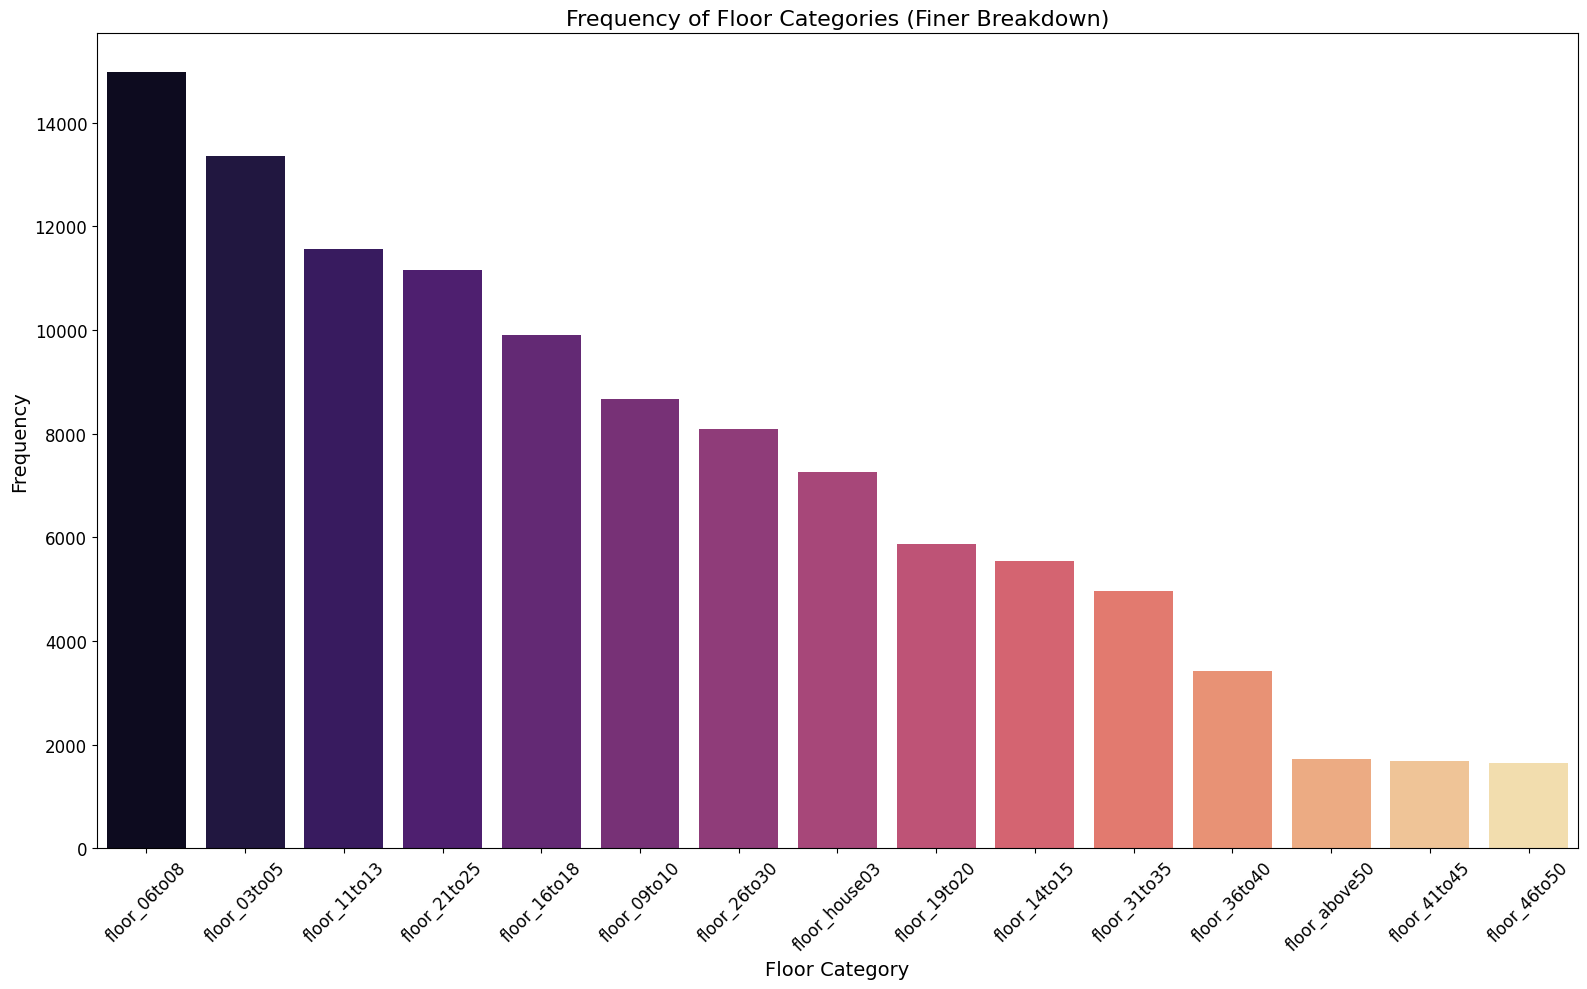

floor_height
floor_06to08     14972
floor_03to05     13347
floor_11to13     11563
floor_21to25     11153
floor_16to18      9898
floor_09to10      8667
floor_26to30      8082
floor_house03     7265
floor_19to20      5880
floor_14to15      5543
floor_31to35      4972
floor_36to40      3432
floor_above50     1728
floor_41to45      1693
floor_46to50      1656
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Updated function to categorize floor heights with finer zones
def categorize_floor_v7(floor):
    if floor < 3:
        return "floor_house03"  # Floors less than 3
    elif 3 <= floor <= 5:
        return "floor_03to05"  # Floors 3 to 5
    elif 6 <= floor <= 8:
        return "floor_06to08"  # Floors 6 to 8
    elif 9 <= floor <= 10:
        return "floor_09to10"  # Floors 9 to 10
    elif 11 <= floor <= 13:
        return "floor_11to13"  # Floors 11 to 13
    elif 14 <= floor <= 15:
        return "floor_14to15"  # Floors 14 to 15
    elif 16 <= floor <= 18:
        return "floor_16to18"  # Floors 16 to 18
    elif 19 <= floor <= 20:
        return "floor_19to20"  # Floors 19 to 20
    elif 21 <= floor <= 25:
        return "floor_21to25"  # Floors 21 to 25
    elif 26 <= floor <= 30:
        return "floor_26to30"  # Floors 26 to 30
    elif 31 <= floor <= 35:
        return "floor_31to35"  # Floors 31 to 35
    elif 36 <= floor <= 40:
        return "floor_36to40"  # Floors 36 to 40
    elif 41 <= floor <= 45:
        return "floor_41to45"  # Floors 41 to 45
    elif floor > 50:
        return "floor_above50"  # Floors above 50
    else:
        return "floor_46to50"  # Floors 46 to 50

# Apply the updated categorization to the dataset
merged_dataset['floor_height'] = merged_dataset['floor'].apply(categorize_floor_v7)

# Frequency count for the new categories
category_counts_v7 = merged_dataset['floor_height'].value_counts()

# Plot the updated category frequencies
plt.figure(figsize=(16, 10))  # Larger figure size for more categories
sns.barplot(x=category_counts_v7.index, y=category_counts_v7.values, palette="magma")

# Add labels and title with larger font sizes
plt.xlabel("Floor Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of Floor Categories (Finer Breakdown)", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Ensure everything fits well
plt.show()

# Display the summarized counts
print(category_counts_v7)

# CREATING FEATURE FLOOR PROPERTY SIZES

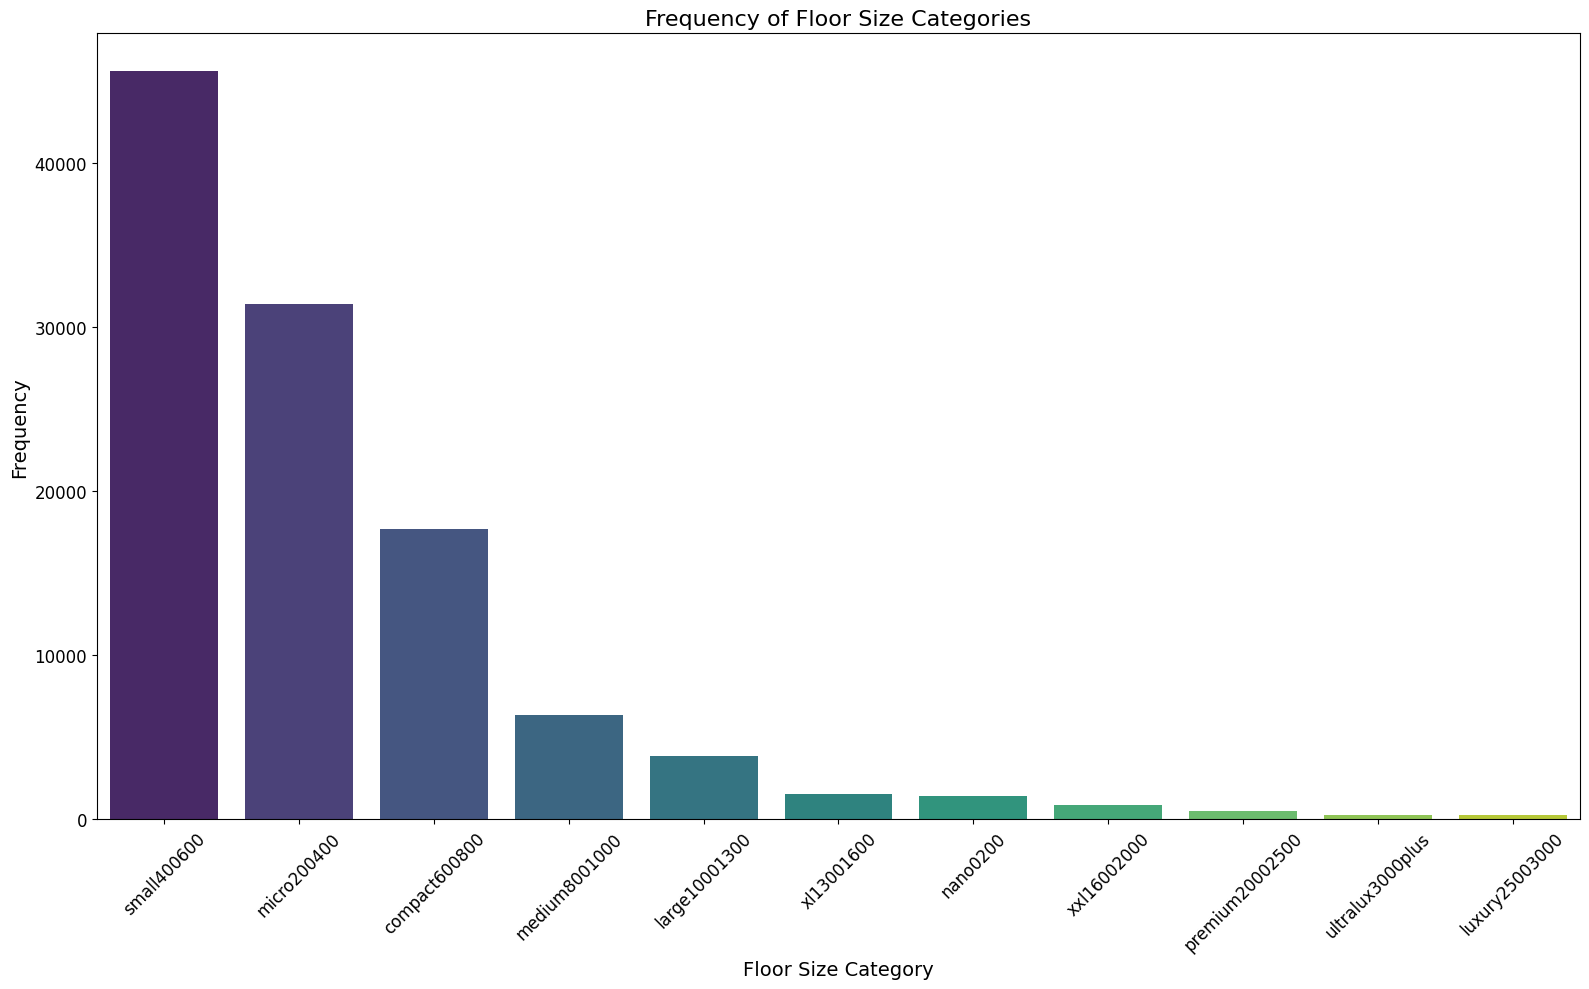

floor_size
small400600         45602
micro200400         31397
compact600800       17703
medium8001000        6376
large10001300        3875
xl13001600           1534
nano0200             1455
xxl16002000           874
premium20002500       526
ultralux3000plus      257
luxury25003000        252
Name: count, dtype: int64


In [ ]:
# Ensure the column 'saleable_area(ft^2)' is converted to numeric
merged_dataset['saleable_area(ft^2)'] = pd.to_numeric(merged_dataset['saleable_area(ft^2)'], errors='coerce')

# Updated categorization function for floor size based on saleable_area(ft^2)
def categorize_floor_size(saleable_area):
    if pd.isna(saleable_area):  # Handle NaN values
        return "unknown"  # Assign a category for missing or invalid data
    elif saleable_area < 200:
        return "nano0200"  # Size less than 200 sq ft
    elif 200 <= saleable_area < 400:
        return "micro200400"  # Size between 200 and 400 sq ft
    elif 400 <= saleable_area < 600:
        return "small400600"  # Size between 400 and 600 sq ft
    elif 600 <= saleable_area < 800:
        return "compact600800"  # Size between 600 and 800 sq ft
    elif 800 <= saleable_area < 1000:
        return "medium8001000"  # Size between 800 and 1000 sq ft
    elif 1000 <= saleable_area < 1300:
        return "large10001300"  # Size between 1000 and 1300 sq ft
    elif 1300 <= saleable_area < 1600:
        return "xl13001600"  # Size between 1300 and 1600 sq ft
    elif 1600 <= saleable_area < 2000:
        return "xxl16002000"  # Size between 1600 and 2000 sq ft
    elif 2000 <= saleable_area < 2500:
        return "premium20002500"  # Size between 2000 and 2500 sq ft
    elif 2500 <= saleable_area < 3000:
        return "luxury25003000"  # Size between 2500 and 3000 sq ft
    else:
        return "ultralux3000plus"  # Size greater than 3000 sq ft

# Apply the categorization function to the merged_dataset
merged_dataset['floor_size'] = merged_dataset['saleable_area(ft^2)'].apply(categorize_floor_size)

# Frequency count for the new floor size categories
size_category_counts = merged_dataset['floor_size'].value_counts()

# Plot the frequency of floor size categories
plt.figure(figsize=(16, 10))  # Larger figure size for better visualization
sns.barplot(x=size_category_counts.index, y=size_category_counts.values, palette="viridis")

# Add labels and title with larger font sizes
plt.xlabel("Floor Size Category", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Frequency of Floor Size Categories", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Ensure everything fits well
plt.show()

# Display the summarized counts
print(size_category_counts)

# PRICE

In [ ]:
merged_dataset.columns

Index(['saleable_area(ft^2)', 'unit_rate', 'district', 'floor', 'CPI', 'PC',
       'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV', 'HS', 'SOLD',
       'PG', 'LS', 'FormattedDate', 'new_price', 'YearQuarter', 'region',
       'floor_height', 'floor_size'],
      dtype='object')

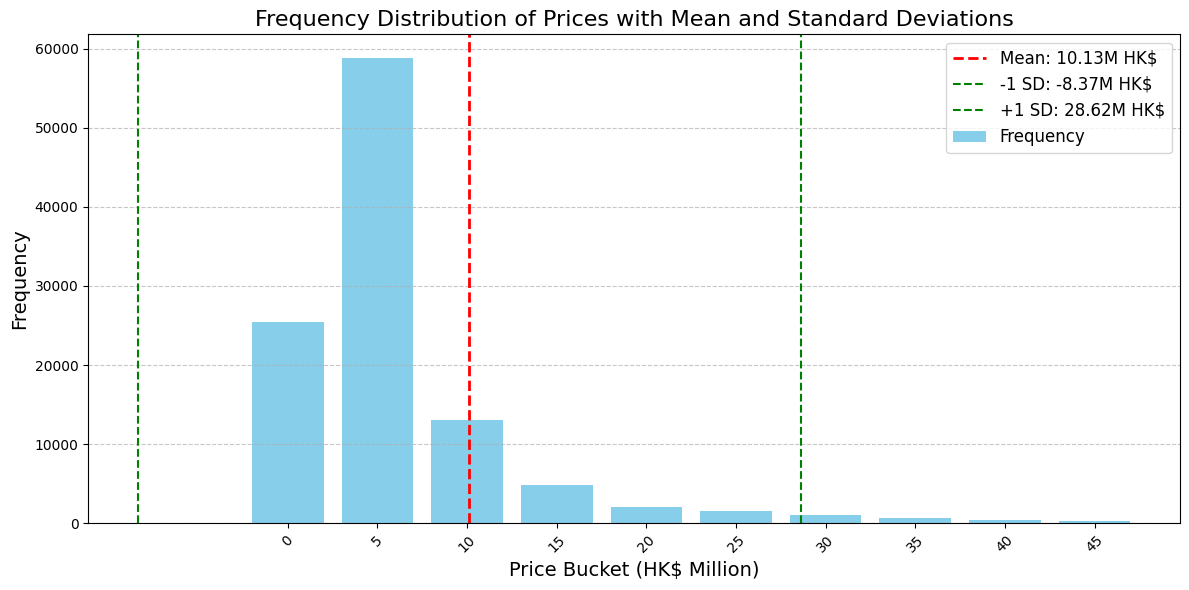

In [ ]:

# Create buckets of 5 million HK$ increments
bucket_size = 5  # Bucket size in million HK$
merged_dataset['price_bucket'] = np.floor(merged_dataset['new_price'] / (bucket_size * 1e6)) * bucket_size

# Group by price_bucket and calculate frequency
frequency_data = (
    merged_dataset
    .groupby('price_bucket')
    .size()
    .reset_index(name='frequency')
    .sort_values(by='price_bucket')
)

# Calculate mean and standard deviation of the prices (in HK$ million)
mean_price = merged_dataset['new_price'].mean() / 1e6  # Convert to HK$ million
std_price = merged_dataset['new_price'].std() / 1e6  # Convert to HK$ million

# Filter the frequency data to focus on values within ±2 standard deviations from the mean
min_bucket = max(0, mean_price - 2 * std_price)  # Avoid negative buckets
max_bucket = mean_price + 2 * std_price
filtered_data = frequency_data[
    (frequency_data['price_bucket'] >= min_bucket) &
    (frequency_data['price_bucket'] <= max_bucket)
]

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(filtered_data['price_bucket'], filtered_data['frequency'], width=4, color='skyblue', label='Frequency')

# Overlay mean price and standard deviation ranges
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_price:.2f}M HK$')
plt.axvline(mean_price - std_price, color='green', linestyle='--', linewidth=1.5, label=f'-1 SD: {mean_price - std_price:.2f}M HK$')
plt.axvline(mean_price + std_price, color='green', linestyle='--', linewidth=1.5, label=f'+1 SD: {mean_price + std_price:.2f}M HK$')

# Add chart details
plt.title('Frequency Distribution of Prices with Mean and Standard Deviations', fontsize=16)
plt.xlabel('Price Bucket (HK$ Million)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(filtered_data['price_bucket'], rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
merged_dataset.columns


Index(['saleable_area(ft^2)', 'unit_rate', 'district', 'floor', 'CPI', 'PC',
       'IR', 'MW', 'M3', 'SD', 'UR', 'GDP', 'CI', 'HSI', 'LTV', 'HS', 'SOLD',
       'PG', 'LS', 'FormattedDate', 'new_price', 'YearQuarter', 'region',
       'floor_height', 'floor_size', 'price_bucket'],
      dtype='object')

Based on the above, ther are many price outliers in the dataset, which may represent extremely high-priced properties which many be individual blocks of whole flats rather than individual flats or more likely erroneous low-priced entries. These outliers will distort machine learning models, especially linear and distance-based algorithms, leading to biased predictions and poor performance. Therefore roperties priced above 3 standard deviations (SD) from the mean (e.g., >37.88M HK$) are considered to be errors or unrepresentative of the majority of the data. To improve model accuracy, these outliers should be removed. Additionally, properties with prices ≤0 should also be eliminated as they are invalid entries. Cleaning the dataset by removing these extreme outliers ensures that the model trains on a more representative and reliable dataset.

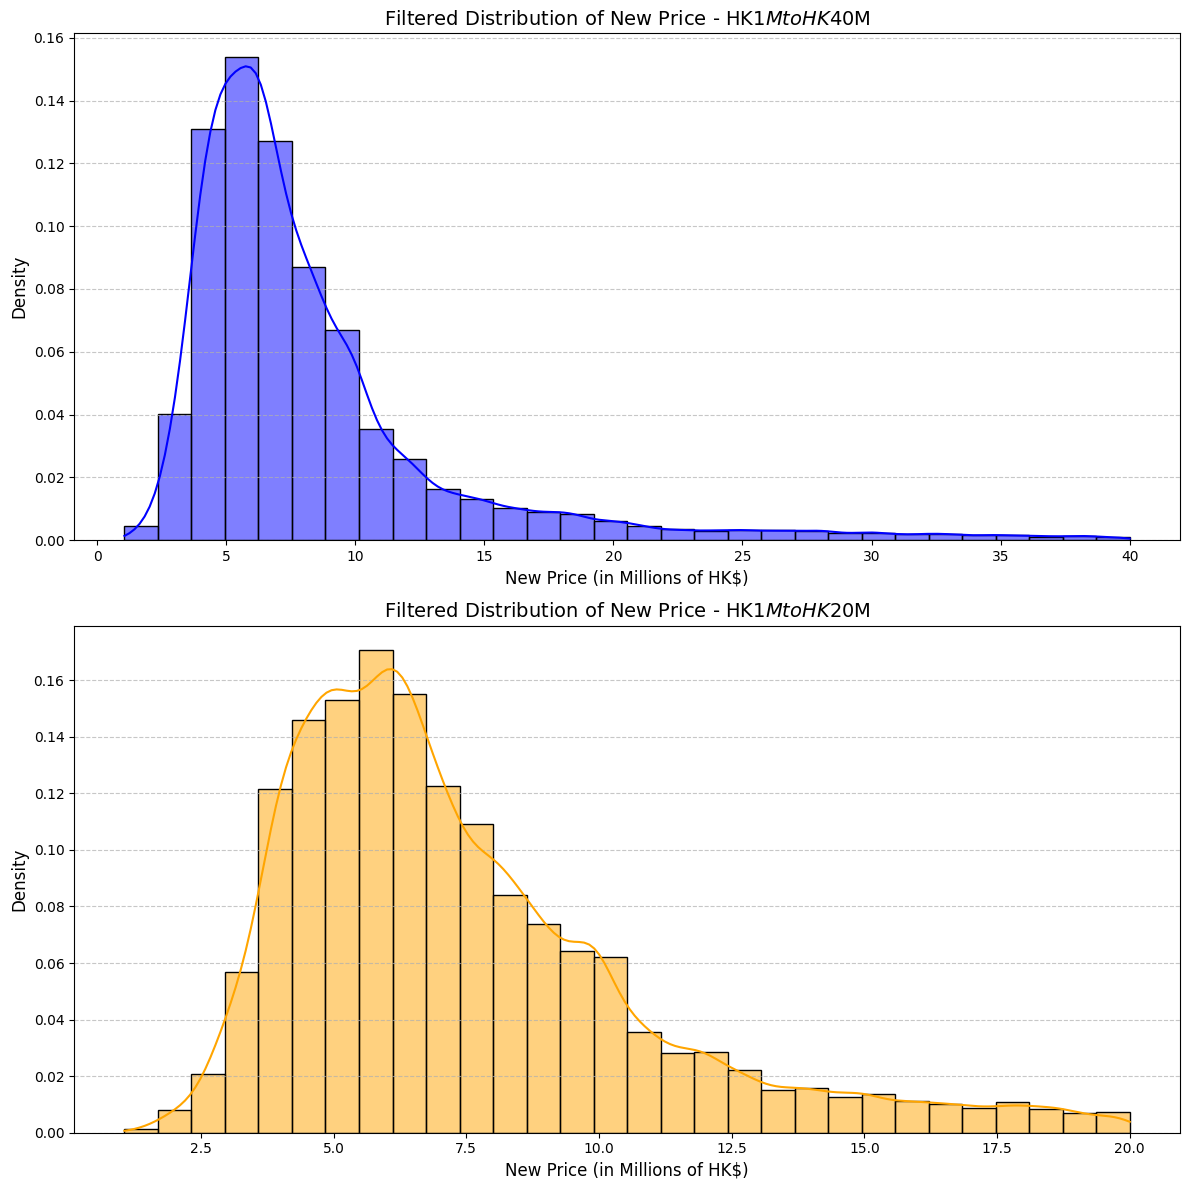

In [ ]:
# Look at the price distribution over certain price ranges
# Check if the column 'new_price' exists
if 'new_price' not in merged_dataset.columns:
    raise ValueError("The column 'new_price' does not exist in the merged_dataset.")

# Filter dataset for new_price between 1,000,000 and 40,000,000
filtered_dataset140 = merged_dataset[(merged_dataset['new_price'] <= 40_000_000) &
                                      (merged_dataset['new_price'] >= 1_000_000)]

# Filter dataset for new_price between 1,000,000 and 20,000,000
filtered_dataset120 = merged_dataset[(merged_dataset['new_price'] <= 20_000_000) &
                                      (merged_dataset['new_price'] >= 1_000_000)]

# Save both datasets to CSV for future use
filtered_dataset140.to_csv('filtered_dataset140.csv', index=False)
filtered_dataset120.to_csv('filtered_dataset120.csv', index=False)

# Convert new_price to millions for plotting in both datasets
filtered_dataset140['new_price_millions'] = filtered_dataset140['new_price'] / 1_000_000
filtered_dataset120['new_price_millions'] = filtered_dataset120['new_price'] / 1_000_000

# Create a figure with two subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Plot the distribution for filtered_dataset140
sns.histplot(filtered_dataset140['new_price_millions'], kde=True, bins=30, color='blue', stat="density", ax=axes[0])
axes[0].set_title('Filtered Distribution of New Price - HK$1M to HK$40M', fontsize=14)
axes[0].set_xlabel('New Price (in Millions of HK$)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the distribution for filtered_dataset120
sns.histplot(filtered_dataset120['new_price_millions'], kde=True, bins=30, color='orange', stat="density", ax=axes[1])
axes[1].set_title('Filtered Distribution of New Price - HK$1M to HK$20M', fontsize=14)
axes[1].set_xlabel('New Price (in Millions of HK$)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the combined plot
plt.show()

I consider that the graph (HK$1M to HK$20M) is better for machine learning as it focuses on the majority of data, reduces skewness, and avoids the influence of outliers, making it easier for models to learn patterns. The left graph (HK$1M to HK$40M) is better if your task requires analyzing the entire market, including high-value properties, but it will require preprocessing (e.g., outlier handling or log transformation) to address skewness and imbalance caused by extreme prices.

# UNIT RATES

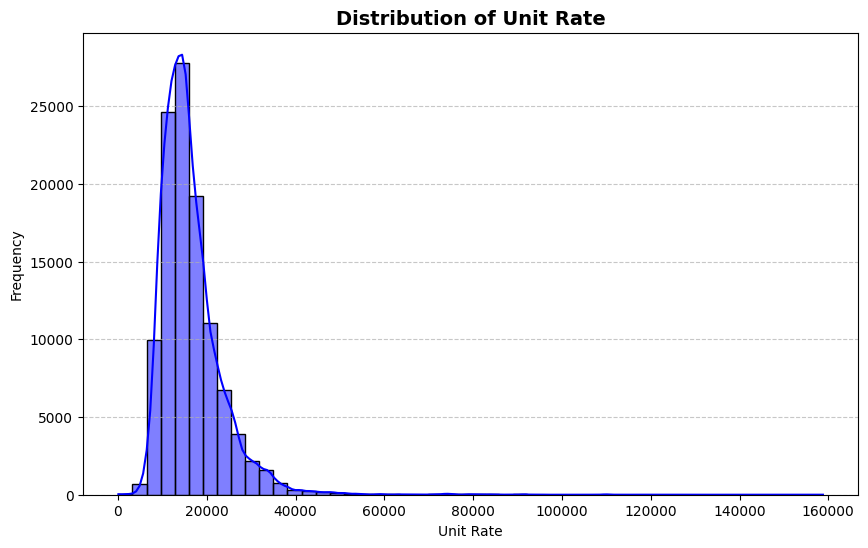

In [ ]:
# Plot the histogram for 'unit_rate'
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_dataset, x='unit_rate', bins=50, kde=True, color='blue')
plt.title('Distribution of Unit Rate', fontsize=14, fontweight='bold')
plt.xlabel('Unit Rate')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The unit Rate distribution is heavily right-skewed, with most values between 5,000 and 25,000 and outliers extending up to 160,000. These outliers, likely luxury properties or data errors, and the wide range make it hard for ML models to generalize. This could be fixed by log transformation or removing outliers to address the skewness. This right skewedness may obscure meaningful associations or lead to overfitting, especially if important patterns in extreme values are lost.

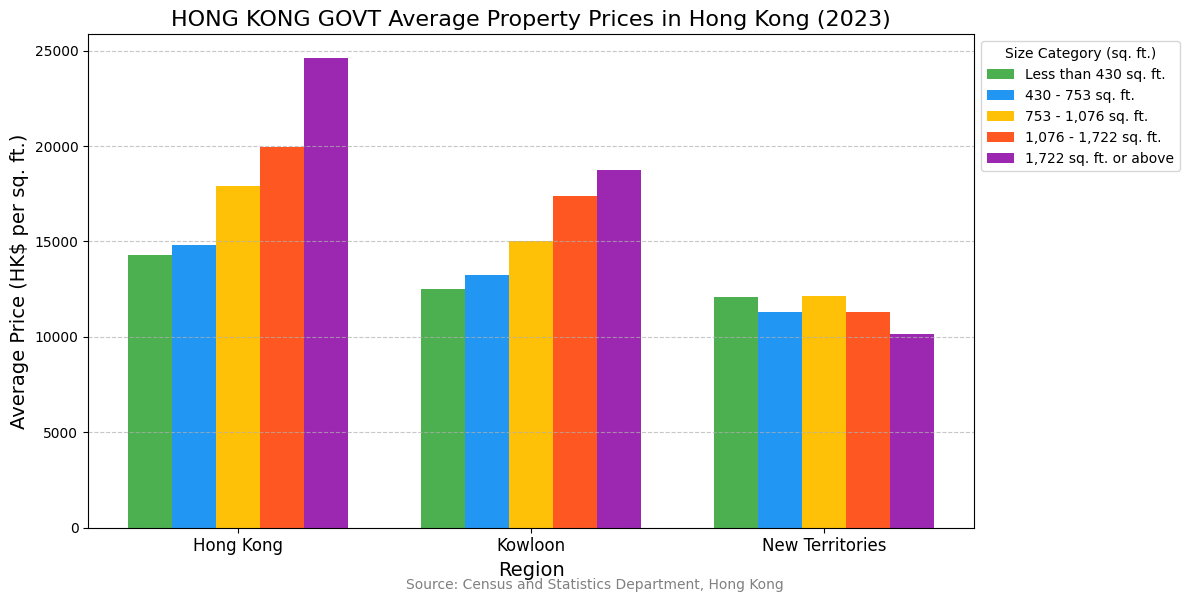

In [ ]:
# Govt data on area price and districts
# Data from the provided table
data = {
    "Type": [
        "Less than 430 sq. ft.",
        "Less than 430 sq. ft.",
        "Less than 430 sq. ft.",
        "430 - 753 sq. ft.",
        "430 - 753 sq. ft.",
        "430 - 753 sq. ft.",
        "753 - 1,076 sq. ft.",
        "753 - 1,076 sq. ft.",
        "753 - 1,076 sq. ft.",
        "1,076 - 1,722 sq. ft.",
        "1,076 - 1,722 sq. ft.",
        "1,076 - 1,722 sq. ft.",
        "1,722 sq. ft. or above",
        "1,722 sq. ft. or above",
        "1,722 sq. ft. or above",
    ],
    "Area/District": [
        "Hong Kong",
        "Kowloon",
        "New Territories",
        "Hong Kong",
        "Kowloon",
        "New Territories",
        "Hong Kong",
        "Kowloon",
        "New Territories",
        "Hong Kong",
        "Kowloon",
        "New Territories",
        "Hong Kong",
        "Kowloon",
        "New Territories",
    ],
    "2023": [
        14314, 12506, 12071,
        14831, 13223, 11315,
        17905, 15028, 12142,
        19972, 17393, 11302,
        24622, 18746, 10141,
    ],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pivot the data to organize it for plotting
pivot_df = df.pivot(index="Area/District", columns="Type", values="2023")

# Define the size categories and regions
size_categories = [
    "Less than 430 sq. ft.",
    "430 - 753 sq. ft.",
    "753 - 1,076 sq. ft.",
    "1,076 - 1,722 sq. ft.",
    "1,722 sq. ft. or above",
]
regions = ["Hong Kong", "Kowloon", "New Territories"]

# Bar position setup
x = np.arange(len(regions))  # Number of regions
bar_width = 0.15  # Width of each bar
offsets = np.arange(-2, 3) * bar_width  # Offsets for each size category

# Plot the data
plt.figure(figsize=(12, 6))

colors = ["#4CAF50", "#2196F3", "#FFC107", "#FF5722", "#9C27B0"]  # Colors for size categories

for i, size_category in enumerate(size_categories):
    plt.bar(
        x + offsets[i],
        pivot_df[size_category],  # Use the pivoted data for the specific size category
        width=bar_width,
        color=colors[i],
        label=size_category,
    )

# Add labels and legend
plt.title("HONG KONG GOVT Average Property Prices in Hong Kong (2023)", fontsize=16)
plt.xlabel("Region", fontsize=14)
plt.ylabel("Average Price (HK$ per sq. ft.)", fontsize=14)
plt.xticks(x, regions, fontsize=12)
plt.legend(title="Size Category (sq. ft.)", fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add source at the bottom of the graph
plt.figtext(
    0.5, 0.01,  # Position: centered horizontally (0.5), near the bottom (0.01)
    "Source: Census and Statistics Department, Hong Kong",
    ha="center",  # Horizontal alignment
    fontsize=10,
    color="gray",
)

plt.tight_layout()

# Show the plot
plt.show()

The data provided by the HK government offers a general guide to property prices by region and area, showing trends across property sizes. However, it is smoothed and aggregated, masking outliers and extreme values. **Hong Kong Island** has the highest prices, with small units at **HK$15,000–20,000 per sq. ft.** and larger ones exceeding **HK$25,000 per sq. ft.** **Kowloon** prices range from **HK$13,000–22,000 per sq. ft.**, while the **New Territories** is more affordable at **HK$10,000–16,000 per sq. ft.**

<Figure size 1400x800 with 0 Axes>

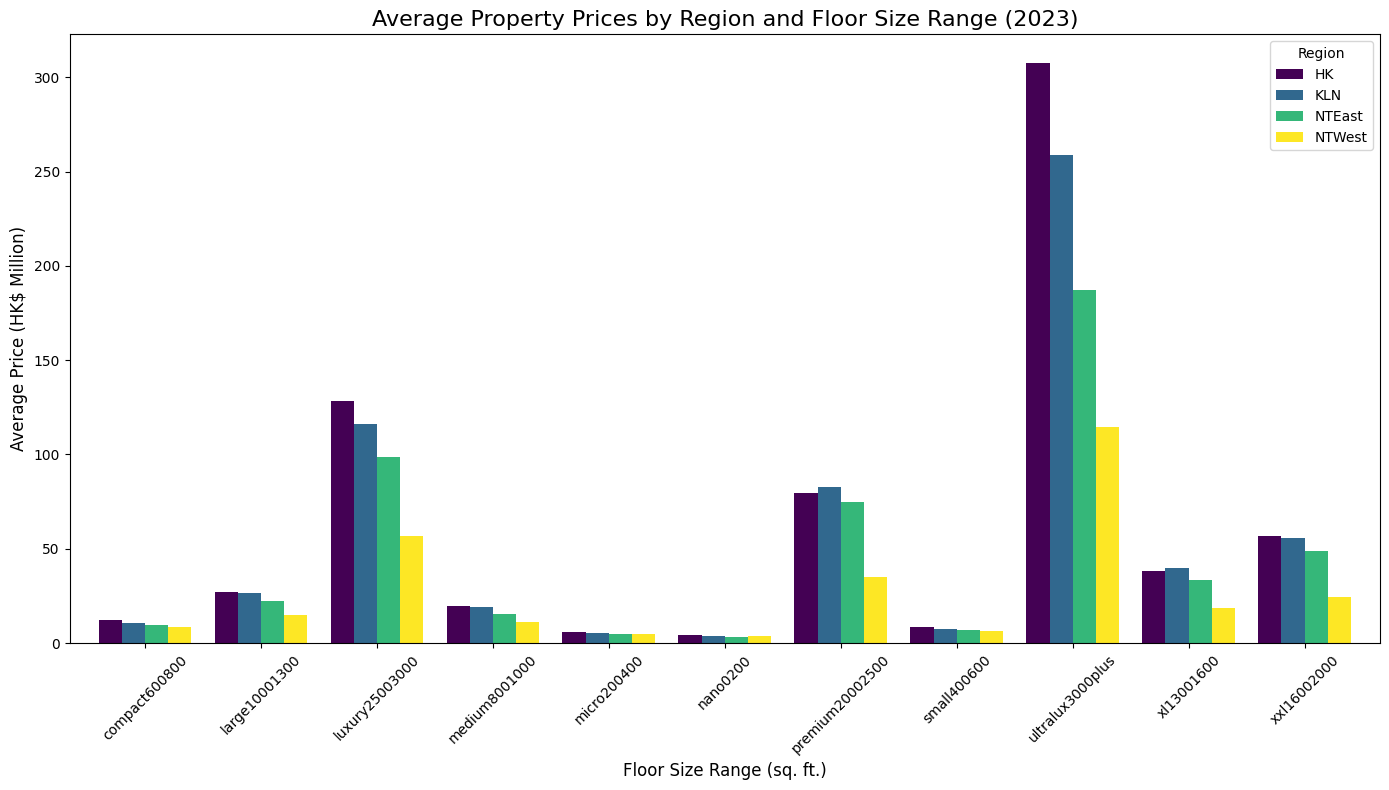

In [ ]:
#Compare data set data
# Group by region and floor size range, calculate the average price
grouped_data = (
    merged_dataset
    .groupby(['region', 'floor_size'])['new_price']
    .mean()
    .reset_index()
)

# Scale the prices to HK$ millions
grouped_data['new_price'] = grouped_data['new_price'] / 1_000_000

# Pivot the data for better visualization (regions as columns)
pivot_data = grouped_data.pivot(index='floor_size', columns='region', values='new_price')

# Plotting the grouped data
plt.figure(figsize=(14, 8))  # Adjust figure size
pivot_data.plot(kind='bar', figsize=(14, 8), colormap='viridis', width=0.8)

# Add labels, title, and legend
plt.title("Average Property Prices by Region and Floor Size Range (2023)", fontsize=16)
plt.xlabel("Floor Size Range (sq. ft.)", fontsize=12)
plt.ylabel("Average Price (HK$ Million)", fontsize=12)  # Update the y-axis label
plt.legend(title="Region", fontsize=10)
plt.xticks(rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

The government data indicates most property transactions occur in Kowloon and the New Territories, but this is not reflected in the dataset, likely due to underreporting. This imbalance skews machine learning (ML) models toward Hong Kong Island's high-value properties, reducing their accuracy for mid-to-low price segments in underrepresented areas. The model may overemphasize luxury trends, misrepresent regional importance, and fail to generalize across the entire market. Feature associations like price per sq. ft. will also be distorted, making predictions unreliable for Kowloon and New Territories. To address this, data balancing, error correction (to account for underreporting), and regional segmentation are essential to ensure the model accurately reflects all regions and property types in its predictions.

<Figure size 1400x800 with 0 Axes>

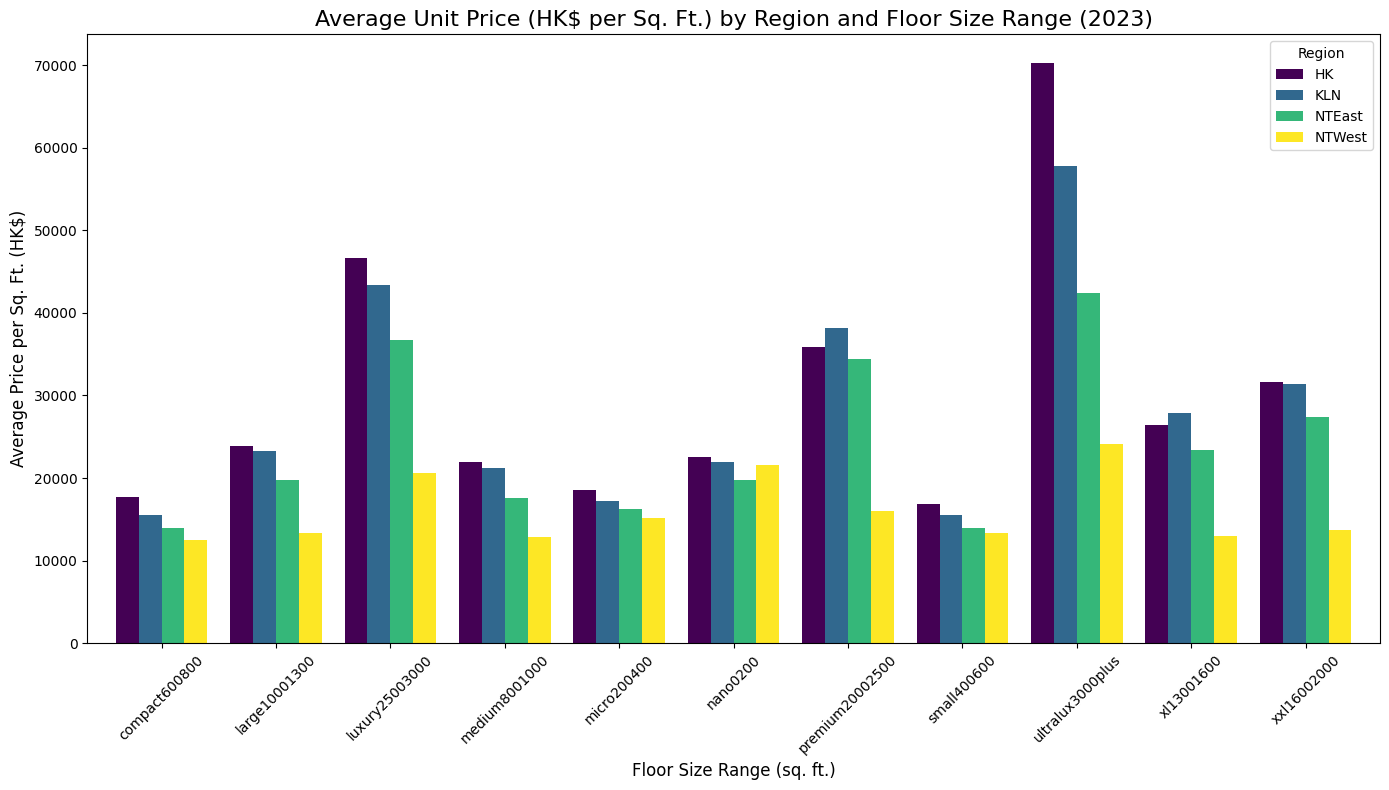

In [ ]:

# Step 1: Group by region and floor size range, calculate the average unit rate
grouped_unit_rate = (
    merged_dataset
    .groupby(['region', 'floor_size'])['unit_rate']
    .mean()
    .reset_index()
)

# Step 2: Pivot the data for better visualization (regions as columns)
pivot_unit_rate = grouped_unit_rate.pivot(index='floor_size', columns='region', values='unit_rate')

# Step 3: Plot the average unit rates
plt.figure(figsize=(14, 8))
pivot_unit_rate.plot(kind='bar', figsize=(14, 8), colormap='viridis', width=0.8)

# Add labels, title, and legend
plt.title("Average Unit Price (HK$ per Sq. Ft.) by Region and Floor Size Range (2023)", fontsize=16)
plt.xlabel("Floor Size Range (sq. ft.)", fontsize=12)
plt.ylabel("Average Price per Sq. Ft. (HK$)", fontsize=12)
plt.legend(title="Region", fontsize=10)
plt.xticks(rotation=45, fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

The chart demonstrates Hong Kong Island's dominance in high average unit prices, especially for luxury properties, overshadowing mid- and low-priced transactions in Kowloon and the New Territories. This imbalance, combined with extreme outliers exceeding HK$70,000 per sq. ft., will severely skews machine learning (ML) models. The result will be overfitting to rare, high-value properties, biased predictions, and poor generalization to typical transactions. Additionally, underrepresentation of Kowloon and New Territories will lead to inaccuracies for these regions and misaligned trends. To address these issues, outliers must be capped or removed to stabilize the dataset, regional segmentation should be applied to account for unique market differences, and data balancing is essential to reflect actual transaction volumes.

Mean: 16422.378958771427, Standard Deviation: 7127.563931937343
Lower Threshold: -4960.312837040601, Upper Threshold: 37805.07075458346
Number of outliers: 1305
Percentage of outliers: 1.19%


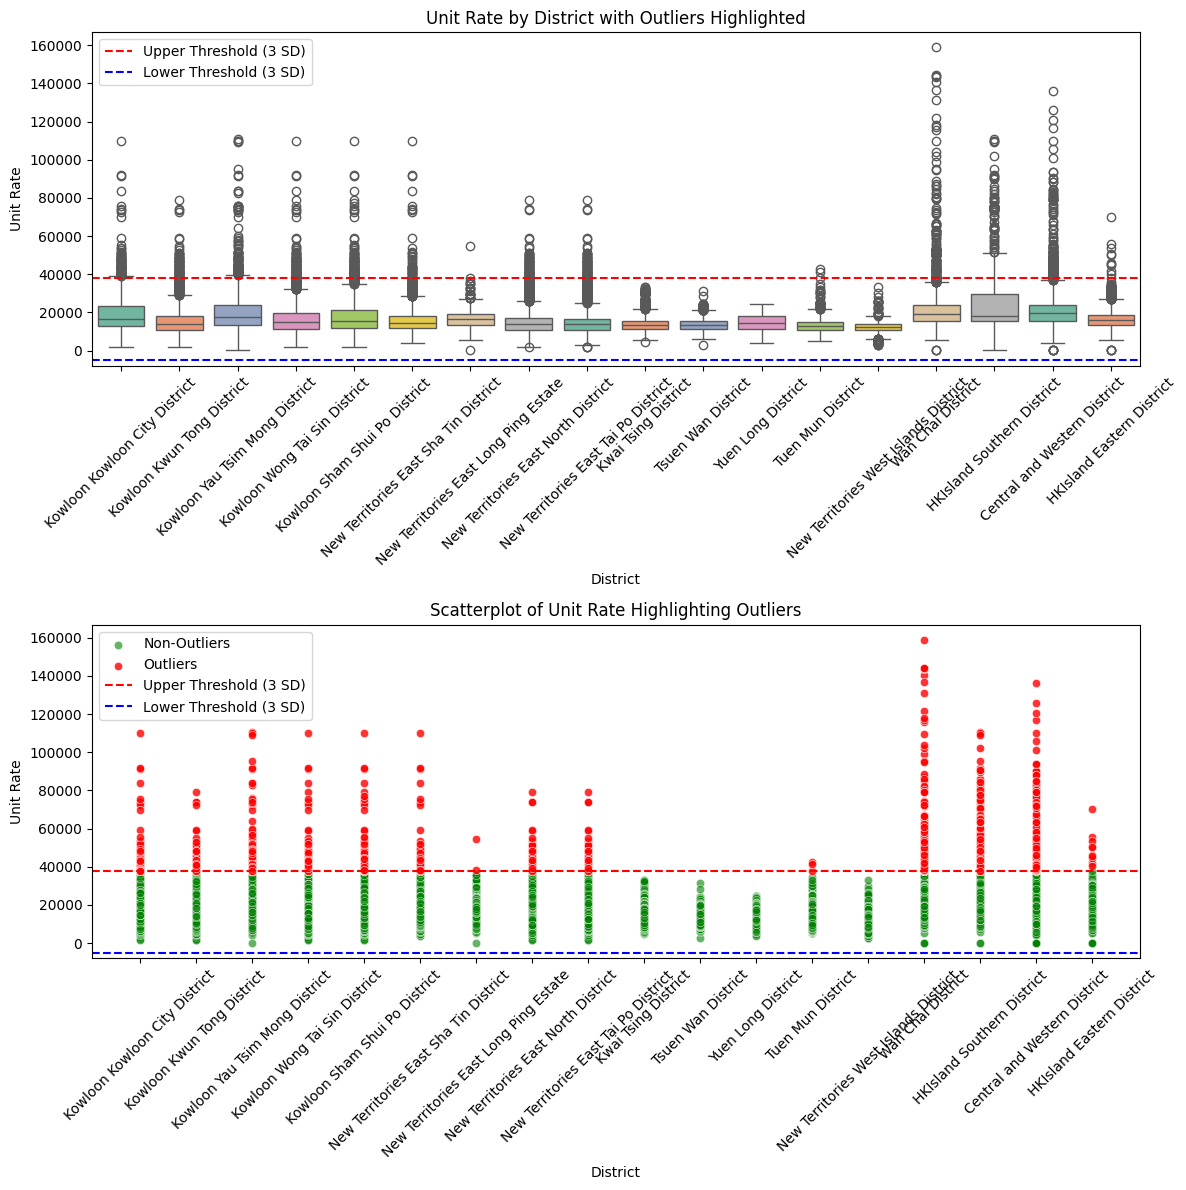

In [ ]:

# Step 1: Calculate mean and standard deviation
mean = merged_dataset['unit_rate'].mean()
std = merged_dataset['unit_rate'].std()

# Step 2: Define outlier thresholds (3 SD from the mean)
lower_threshold = mean - 3 * std
upper_threshold = mean + 3 * std

print(f"Mean: {mean}, Standard Deviation: {std}")
print(f"Lower Threshold: {lower_threshold}, Upper Threshold: {upper_threshold}")

# Step 3: Identify outliers
merged_dataset['is_outlier'] = (merged_dataset['unit_rate'] < lower_threshold) | (merged_dataset['unit_rate'] > upper_threshold)

# Step 4: Separate outliers and non-outliers
outliers = merged_dataset[merged_dataset['is_outlier']]
non_outliers = merged_dataset[~merged_dataset['is_outlier']]

# Print summary
print(f"Number of outliers: {len(outliers)}")
print(f"Percentage of outliers: {len(outliers) / len(merged_dataset) * 100:.2f}%")

# Step 5: Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # Two rows, one column

# Boxplot: Indicating outliers
sns.boxplot(ax=axes[0], data=merged_dataset, x='district', y='unit_rate', palette='Set2', showfliers=True)
axes[0].axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold (3 SD)')
axes[0].axhline(lower_threshold, color='blue', linestyle='--', label='Lower Threshold (3 SD)')
axes[0].set_title('Unit Rate by District with Outliers Highlighted')
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[0].set_xlabel('District')  # Adding x-axis label
axes[0].set_ylabel('Unit Rate')  # Adding y-axis label
axes[0].legend()

# Scatterplot: Highlighting outliers
sns.scatterplot(ax=axes[1], data=non_outliers, x='district', y='unit_rate', color='green', label='Non-Outliers', alpha=0.6)
sns.scatterplot(ax=axes[1], data=outliers, x='district', y='unit_rate', color='red', label='Outliers', alpha=0.8)
axes[1].axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold (3 SD)')
axes[1].axhline(lower_threshold, color='blue', linestyle='--', label='Lower Threshold (3 SD)')
axes[1].set_title('Scatterplot of Unit Rate Highlighting Outliers')
axes[1].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[1].set_xlabel('District')  # Adding x-axis label
axes[1].set_ylabel('Unit Rate')  # Adding y-axis label
axes[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

The dataset contains extreme outliers, with unit rates exceeding HK$140,000 per sq. ft., far above the typical market average of HK$25,000 per sq. ft. These outliers, likely due to errors or rare super-luxury properties, negatively impact machine learning (ML) models. They skew the loss function, forcing the model to focus on unrealistic values, resulting in overfitting and poor generalization to new data. Predictions become inaccurate, overestimating prices for typical properties and underestimating prices in luxury markets.

Dropping outliers using the 3 standard deviation (SD) rule is essential to mitigate these effects. This step removes noise, reduces bias, and allows the model to focus on realistic patterns. By eliminating extreme values, ML algorithms can better learn meaningful relationships, improve accuracy, and produce predictions that align with real market behavior. This preprocessing step is critical for robust, reliable, and interpretable models.

# DISTRICTS

Number of districts: 18


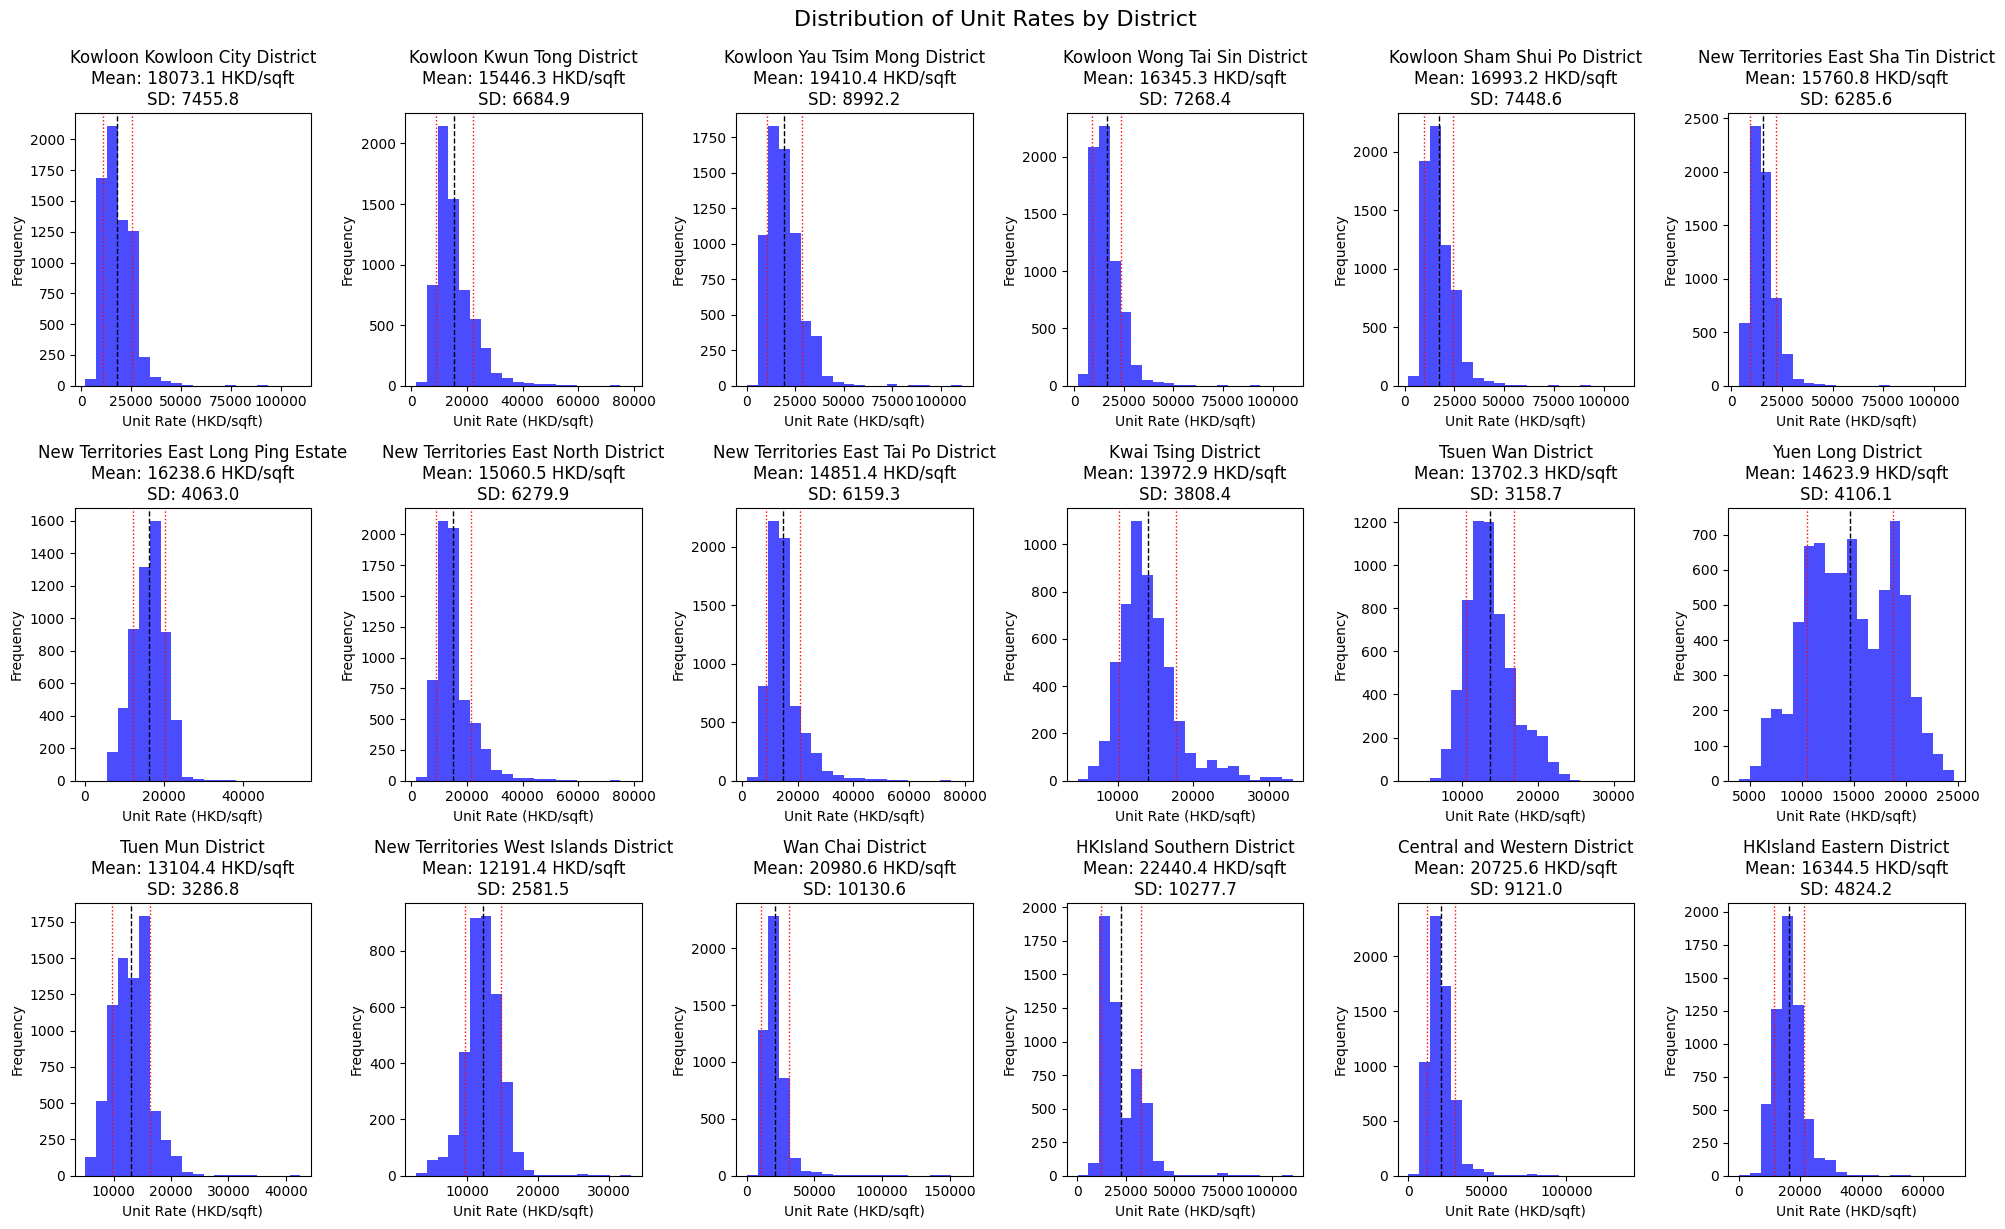

In [ ]:
# Step 1: Check unique districts
districts = merged_dataset['district'].unique()
num_districts = len(districts)
print(f"Number of districts: {num_districts}")  # Should print ~18 districts

# Step 2: Set up the grid for subplots
rows = 3  # Number of rows in the grid
cols = 6  # Number of columns in the grid (adjust based on the number of districts)
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))  # Adjust figure size for readability
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Step 3: Generate subplots for each district
for i, district in enumerate(districts):
    district_data = merged_dataset[merged_dataset['district'] == district]
    unit_rates = district_data['unit_rate']
    mean = np.mean(unit_rates)
    std_dev = np.std(unit_rates)

    # Plot histogram for the current district
    axes[i].hist(
        unit_rates, bins=20, alpha=0.7, color='blue'
    )
    axes[i].axvline(mean, color='black', linestyle='dashed', linewidth=1)  # Mean
    axes[i].axvline(mean - std_dev, color='red', linestyle='dotted', linewidth=1)  # -1 Std Dev
    axes[i].axvline(mean + std_dev, color='red', linestyle='dotted', linewidth=1)  # +1 Std Dev

    # Title and labels
    axes[i].set_title(f'{district}\nMean: {mean:.1f} HKD/sqft\nSD: {std_dev:.1f}')
    axes[i].set_xlabel('Unit Rate (HKD/sqft)')
    axes[i].set_ylabel('Frequency')

# Step 4: Remove unused subplots if districts < total grid slots
for j in range(len(districts), len(axes)):
    fig.delaxes(axes[j])  # Remove empty subplots

# Step 5: Adjust layout and save as one image
plt.tight_layout()
plt.suptitle('Distribution of Unit Rates by District', y=1.02, fontsize=16)  # Add a global title
plt.savefig('district_unit_rate_distributions.png')  # Save as an image file
plt.show()

Considering the frequency curves together with the heat map, it is reasonable to exclude **2020 data**, which may have been incomplete due to the 2020 COVID-19 pandemic. This exclusion ensures sufficient data for machine learning and robust geographic representation. The focus will be on **2021–2023**, where data availability is more consistent across districts. However, districts with sparse data (e.g., Kowloon City, Wong Tai Sin) may cause problems in machine learning, and districts with more complete data, such as those on Hong Kong Island, may be overrepresented in the training of the ML programs.

# PRICE CHANGE

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109851 entries, 7 to 159611
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   saleable_area(ft^2)  109851 non-null  int64         
 1   unit_rate            109851 non-null  int64         
 2   district             109851 non-null  object        
 3   floor                109851 non-null  float64       
 4   CPI                  109851 non-null  int64         
 5   PC                   109851 non-null  int64         
 6   IR                   109851 non-null  int64         
 7   MW                   109851 non-null  int64         
 8   M3                   109851 non-null  int64         
 9   SD                   109851 non-null  int64         
 10  UR                   109851 non-null  int64         
 11  GDP                  109851 non-null  int64         
 12  CI                   109851 non-null  int64         
 13  HSI                

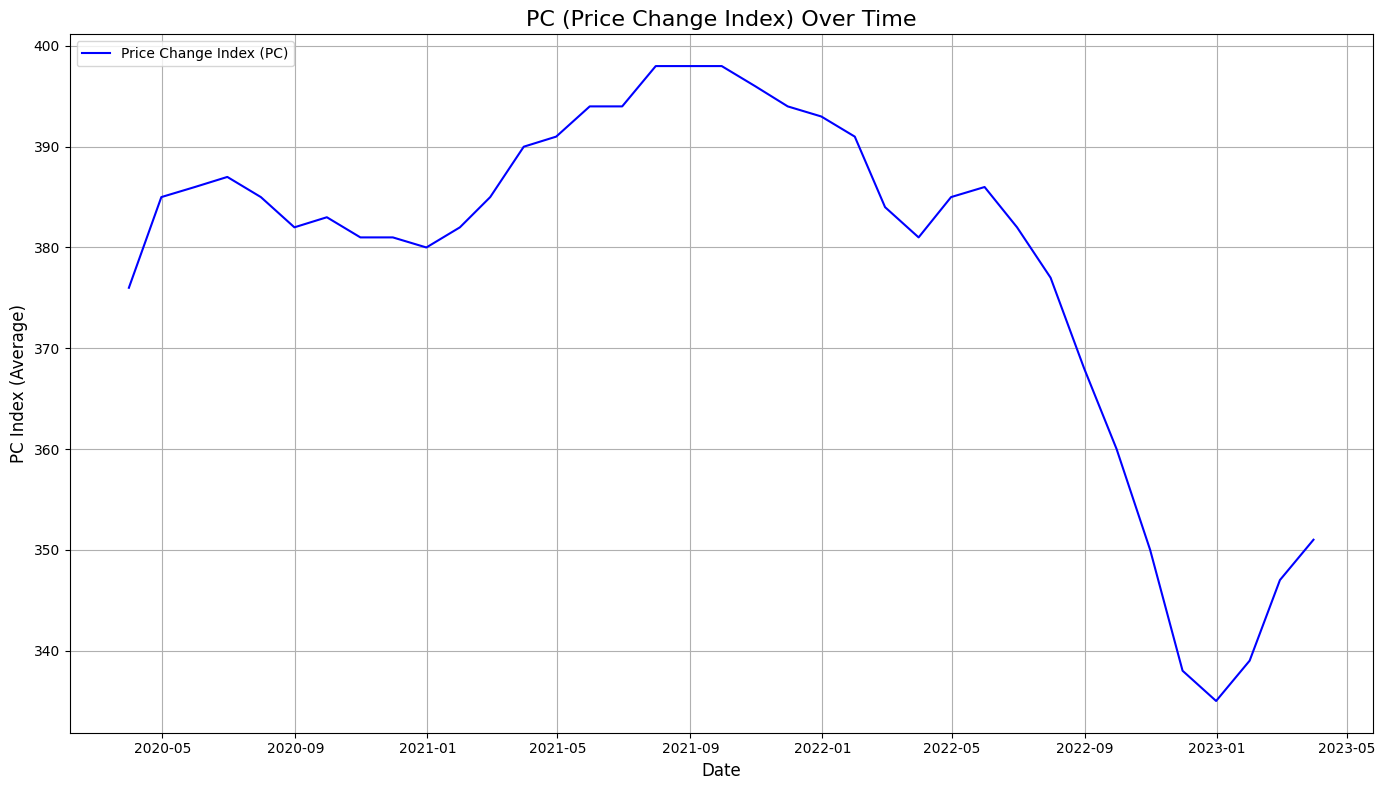

In [ ]:

# Resample PC over time (monthly) using the mean to preserve the index scale
pc_over_time = merged_dataset.resample('M', on='FormattedDate')['PC'].mean()

# Plot the data
plt.figure(figsize=(14, 8))  # Set figure size
plt.plot(pc_over_time.index, pc_over_time, label='Price Change Index (PC)', color='blue')

# Add titles and labels
plt.title('PC (Price Change Index) Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PC Index (Average)', fontsize=12)
plt.grid(True)  # Add grid for better readability
plt.legend(loc='upper left')  # Legend for the line

# Display the plot
plt.tight_layout()
plt.show()

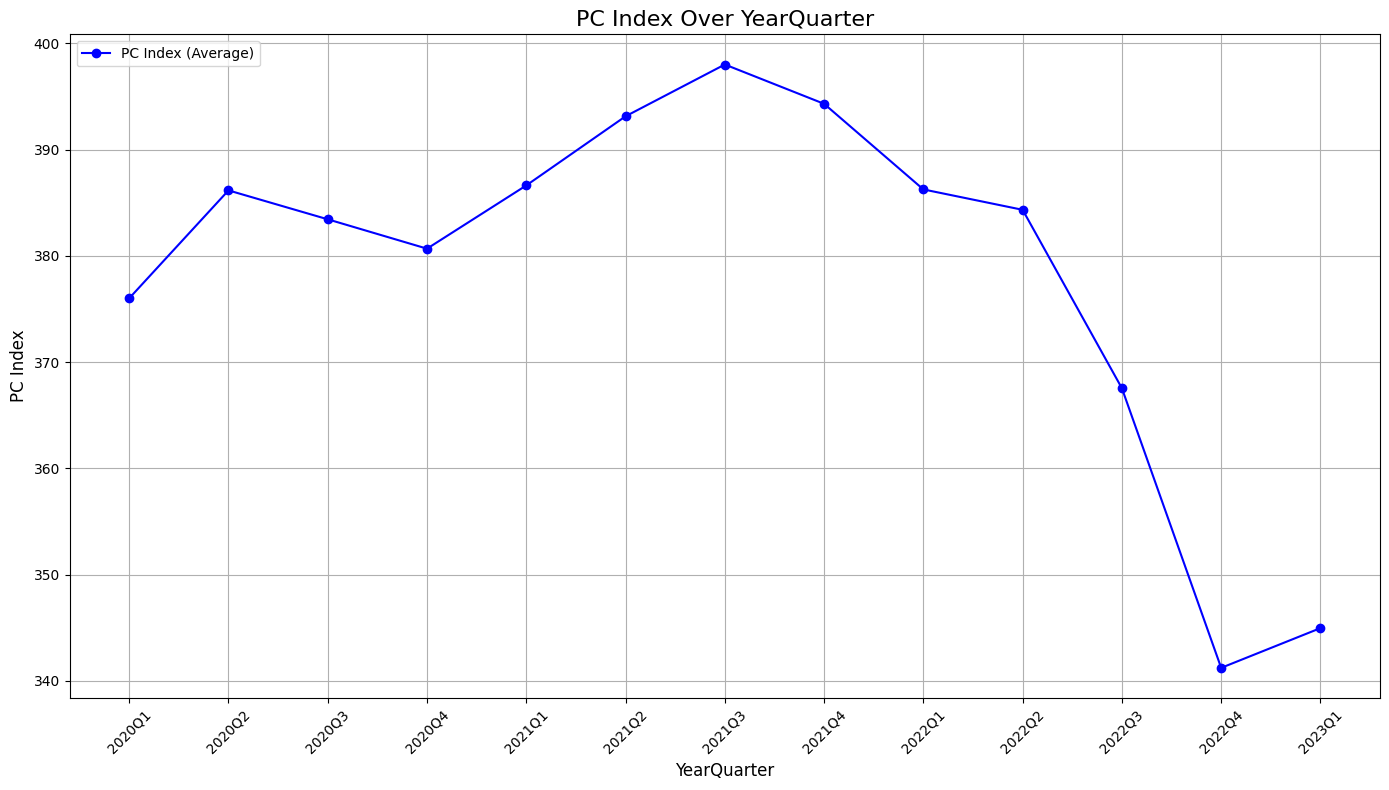

In [ ]:

# Group data by YearQuarter and calculate the average PC index
pc_over_quarters = merged_dataset.groupby('YearQuarter')['PC'].mean()

# Sort the YearQuarter values to ensure proper order
pc_over_quarters = pc_over_quarters.sort_index()

# Plot the data
plt.figure(figsize=(14, 8))  # Set figure size
plt.plot(pc_over_quarters.index, pc_over_quarters, marker='o', label='PC Index (Average)', color='blue')

# Add titles and labels
plt.title('PC Index Over YearQuarter', fontsize=16)
plt.xlabel('YearQuarter', fontsize=12)
plt.ylabel('PC Index', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for better readability
plt.legend(loc='upper left')  # Legend for the line

# Display the plot
plt.tight_layout()
plt.show()

# DATABASE INCOMPLETNESS

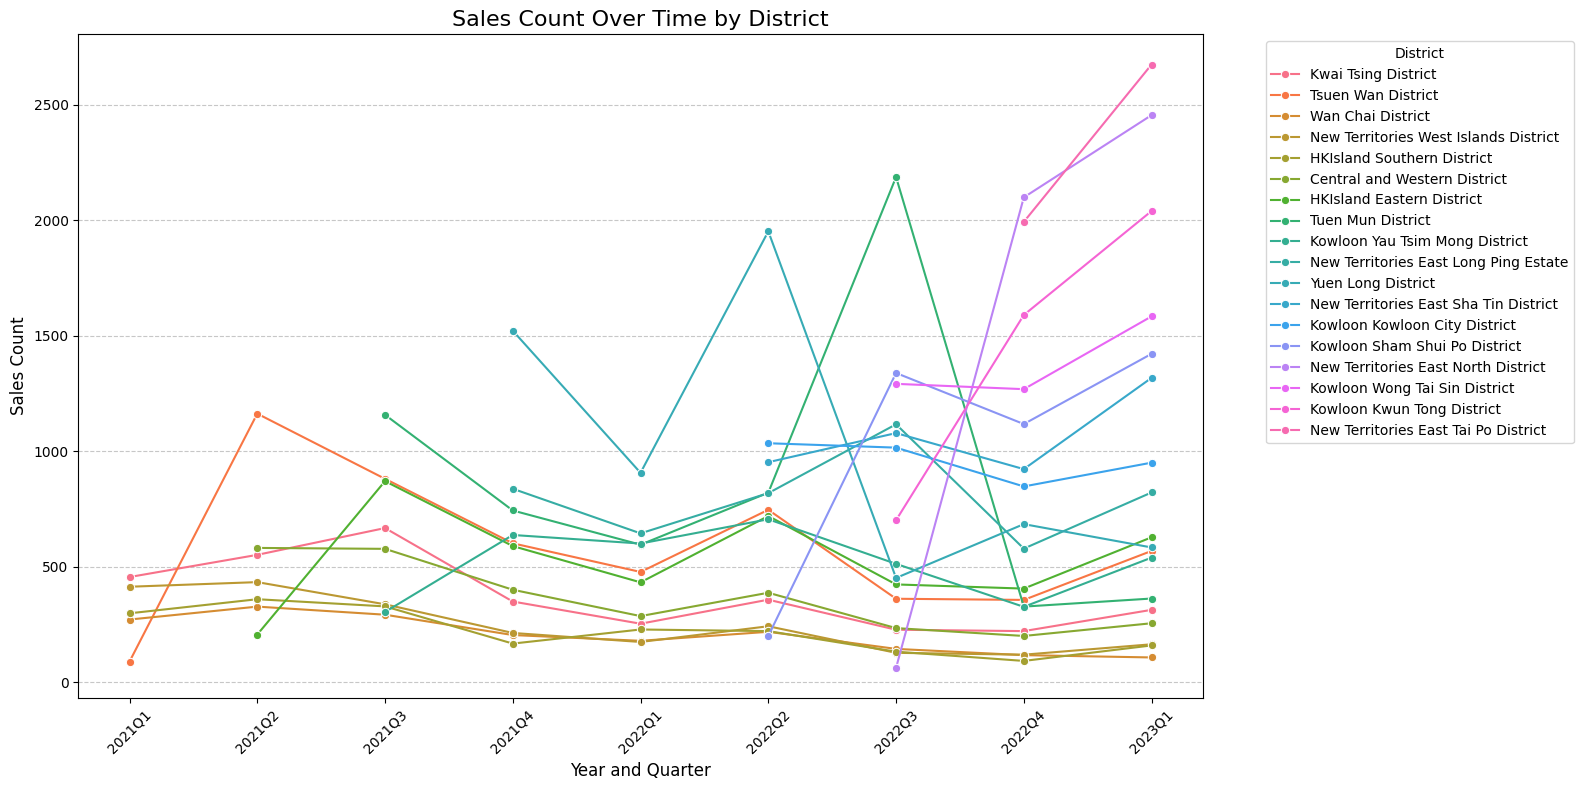

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'district' and 'YearQuarter'
grouped_data = merged_dataset.groupby(['district', 'YearQuarter']).agg(
    Sales_Count=('new_price', 'count')  # Count of sales
).reset_index()

# Convert 'YearQuarter' to a proper datetime-like format for sorting
grouped_data['YearQuarter_Sort'] = pd.to_datetime(
    grouped_data['YearQuarter'].str[:4] + '-' +  # Year
    grouped_data['YearQuarter'].str[5:].replace({'Q1': '01', 'Q2': '04', 'Q3': '07', 'Q4': '10'})  # Start month of each quarter
)

# Sort the data by 'YearQuarter_Sort'
grouped_data = grouped_data.sort_values(by='YearQuarter_Sort').reset_index(drop=True)

# Plot Sales Count Over Time
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=grouped_data,
    x='YearQuarter',
    y='Sales_Count',
    hue='district',
    marker='o'
)
plt.title('Sales Count Over Time by District', fontsize=16)
plt.xlabel('Year and Quarter', fontsize=12)
plt.ylabel('Sales Count', fontsize=12)
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

The lack of early data in early years (2020) and uneven distribution across districts may cause bias as ML models may overfit well-represented areas, disproportionately influencing predictions. Sparse data in some areas will hinders learning by providing insufficient context for trends, especially for underrepresented districts or time periods. This dat could skewing predictions toward trends in overrepresented areas and neglecting sparse regions.

In [ ]:
# Display the first 5 values of the 'new_price' column
print("First 5 new_price values in merged_dataset:")
print(merged_dataset['new_price'].head(5))

First 5 new_price values in merged_dataset:
7      6680016
13    75999570
14    12067177
15     4389440
16     8584779
Name: new_price, dtype: int64


In [ ]:
# Look at the sales in each quarter to see what is missing

# Group by district and YearQuarter, calculating number of sales and average price
summary = merged_dataset.groupby(['district', 'YearQuarter']).agg(
    Sales_Count=('new_price', 'count'),  # Count of sales
    Total_Price=('new_price', 'sum')     # Sum of prices
).reset_index()

# Calculate Average Price per YearQuarter
summary['Average_Price'] = summary['Total_Price'] / summary['Sales_Count']

# Convert Average_Price to HK$ million
summary['Average_Price'] = summary['Average_Price'] / 1000000

# Create a complete list of all districts and YearQuarters
all_districts = summary['district'].unique()
all_yearquarters = summary['YearQuarter'].unique()

# Create a full grid of all combinations
full_index = pd.MultiIndex.from_product([all_districts, all_yearquarters], names=['district', 'YearQuarter'])
full_summary = pd.DataFrame(index=full_index).reset_index()

# Merge with the summary to fill in "no data" where applicable
final_table = pd.merge(full_summary, summary, on=['district', 'YearQuarter'], how='left')

# Fill NaN values with "no data"
final_table['Sales_Count'].fillna("no data", inplace=True)
final_table['Average_Price'].fillna("no data", inplace=True)
final_table['Total_Price'].fillna("no data", inplace=True)
# Sort by YearQuarter and district
final_table.sort_values(by=['YearQuarter', 'district'], inplace=True)

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Display the full summary table
#print(final_table[['district', 'YearQuarter', 'Average_Price', 'Sales_Count']])
final_table.head(20)

,district,YearQuarter,Sales_Count,Total_Price,Average_Price
9,Central and Western District,2020Q1,no data,no data,no data
22,HKIsland Eastern District,2020Q1,no data,no data,no data
35,HKIsland Southern District,2020Q1,64.0,925014605.0,14.453353
48,Kowloon Kowloon City District,2020Q1,no data,no data,no data
61,Kowloon Kwun Tong District,2020Q1,no data,no data,no data
74,Kowloon Sham Shui Po District,2020Q1,no data,no data,no data
87,Kowloon Wong Tai Sin District,2020Q1,no data,no data,no data
100,Kowloon Yau Tsim Mong District,2020Q1,no data,no data,no data
113,Kwai Tsing District,2020Q1,50.0,289081798.0,5.781636
126,New Territories East Long Ping Estate,2020Q1,no data,no data,no data


YearQuarter                            2020Q1  2020Q2  2020Q3  2020Q4  2021Q1  \
district                                                                        
Central and Western District                0       0       0       0       1   
HKIsland Eastern District                   0       0       0       0       0   
HKIsland Southern District                  1       1       1       1       1   
Kowloon Kowloon City District               0       0       0       0       0   
Kowloon Kwun Tong District                  0       0       0       0       0   
Kowloon Sham Shui Po District               0       0       0       0       0   
Kowloon Wong Tai Sin District               0       0       0       0       0   
Kowloon Yau Tsim Mong District              0       0       0       0       0   
Kwai Tsing District                         1       1       1       1       1   
New Territories East Long Ping Estate       0       0       0       0       0   
New Territories East North D

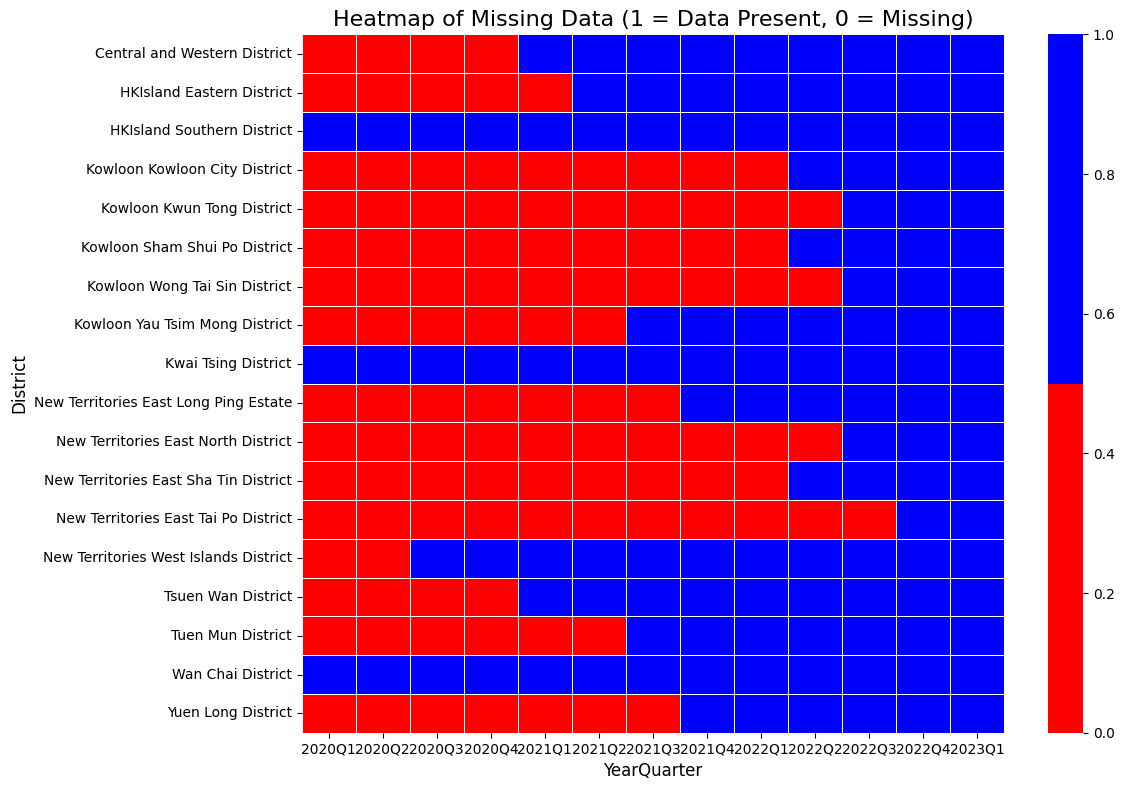

In [ ]:
# Heatmap of missing data in Districts vs YearQuarters
from matplotlib.colors import ListedColormap  # Import ListedColormap

# Replace "no data" with NaN for easier manipulation
final_table['Sales_Count'] = final_table['Sales_Count'].replace("no data", pd.NA)

# Create a matrix to show where data is missing
missing_data_matrix = final_table.pivot(index='district', columns='YearQuarter', values='Sales_Count')

# Convert the missing data to a binary format: 1 for data present, 0 for missing
binary_missing_data = missing_data_matrix.notna().astype(int)

# Display the first 20 rows of the binary matrix (optional, for checking)
print(binary_missing_data.head(20))

# Define a custom colormap: red for 0 (missing data), blue for 1 (data present)
colors = ['#ff0000', '#0000ff']  # Red for missing data, blue for data present
cmap = ListedColormap(colors)

# Plot the heatmap to visualize missing data
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(binary_missing_data, cmap=cmap, cbar=True, linewidths=0.5,
            linecolor='white', xticklabels=True, yticklabels=True)

# Add labels and title
plt.title('Heatmap of Missing Data (1 = Data Present, 0 = Missing)', fontsize=16)
plt.xlabel('YearQuarter', fontsize=12)
plt.ylabel('District', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The heatmap reveals significant data gaps in early quarters (e.g., 2020 Q1–2021 Q4), particularly for districts like Tsuen Wan and Tuen Mun. Well-represented districts, such as Wan Chai, may dominate model learning. Imputation or removal ensures accurate ML predictions.

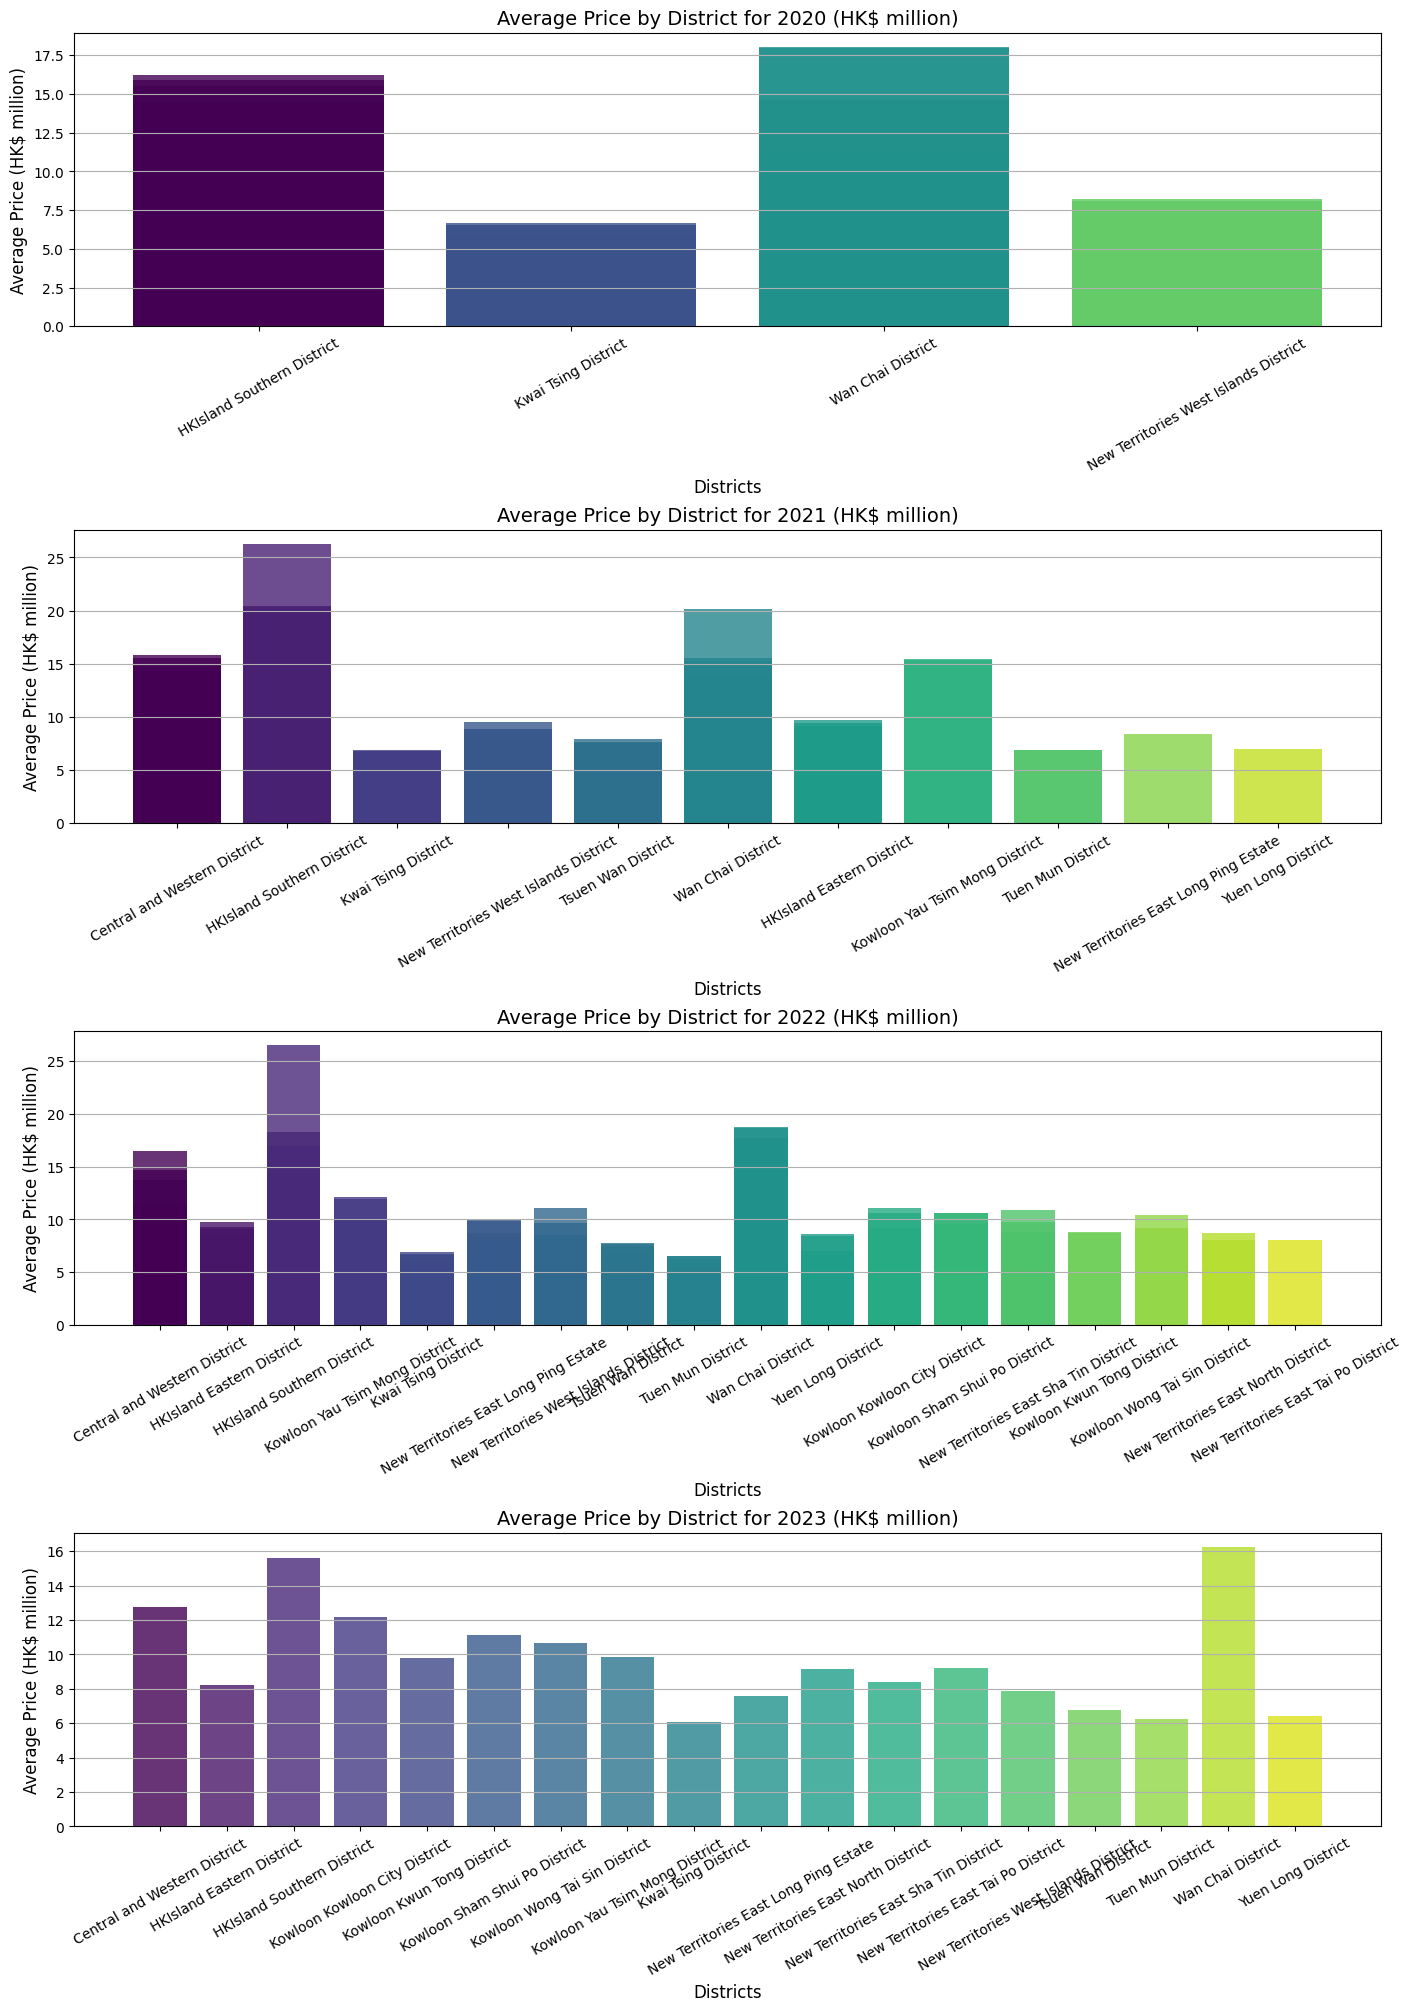

In [ ]:
# Districts over the years
# Filter out rows with "no data" in Average_Price and convert to float
plot_data = final_table[final_table['Average_Price'] != "no data"].copy()
plot_data['Average_Price'] = plot_data['Average_Price'].astype(float)

# Extract the Year from YearQuarter for grouping
plot_data['Year'] = plot_data['YearQuarter'].astype(str).str[:4]  # Get the first 4 characters for the year

# Get the list of unique years for subplots
years = plot_data['Year'].unique()

# Set up the subplots for vertical stacking
fig, axes = plt.subplots(len(years), 1, figsize=(14, 5 * len(years)), constrained_layout=True)

# Use a colormap for unique colors
color_map = plt.cm.viridis

# If there's only one year, axes will not be an array, handle that case
if len(years) == 1:
    axes = [axes]  # Wrap it in a list to iterate consistently

# Loop through each year and plot on separate subplots
for i, year in enumerate(years):
    # Filter data for the current year
    year_data = plot_data[plot_data['Year'] == year]

    # Assign unique colors to each district
    colors = [color_map(idx / len(year_data['district'].unique())) for idx in range(len(year_data['district'].unique()))]
    district_color_map = {district: colors[idx] for idx, district in enumerate(year_data['district'].unique())}

    # Plotting with unique colors
    axes[i].bar(year_data['district'], year_data['Average_Price'],
                color=[district_color_map[district] for district in year_data['district']], alpha=0.8)

    # Adding labels and title
    axes[i].set_title(f'Average Price by District for {year} (HK$ million)', fontsize=14)
    axes[i].set_xlabel('Districts', fontsize=12)
    axes[i].set_ylabel('Average Price (HK$ million)', fontsize=12)
    axes[i].tick_params(axis='x', rotation=30, labelsize=10)  # Rotate x-axis labels for better alignment
    axes[i].grid(axis='y')

# Show the final plot
plt.show()

The graphs show significant price variations across districts and years, with sparse data in early years 2020 to 2021, likely due to COVID-19 disruptions. By 2023, most districts report complete data. Some high-priced districts (e.g., Central and Western) dominate the market, skewing the dataset. This imbalance could bias machine learning models toward wealthier areas, requiring normalization and imputation to ensure accurate, fair predictions across all districts and time periods.

In [ ]:
# Display the first 5 values of the 'new_price' column
print("First 5 new_price values in merged_dataset:")
print(merged_dataset['new_price'].head(5))

First 5 new_price values in merged_dataset:
7      6680016
13    75999570
14    12067177
15     4389440
16     8584779
Name: new_price, dtype: int64


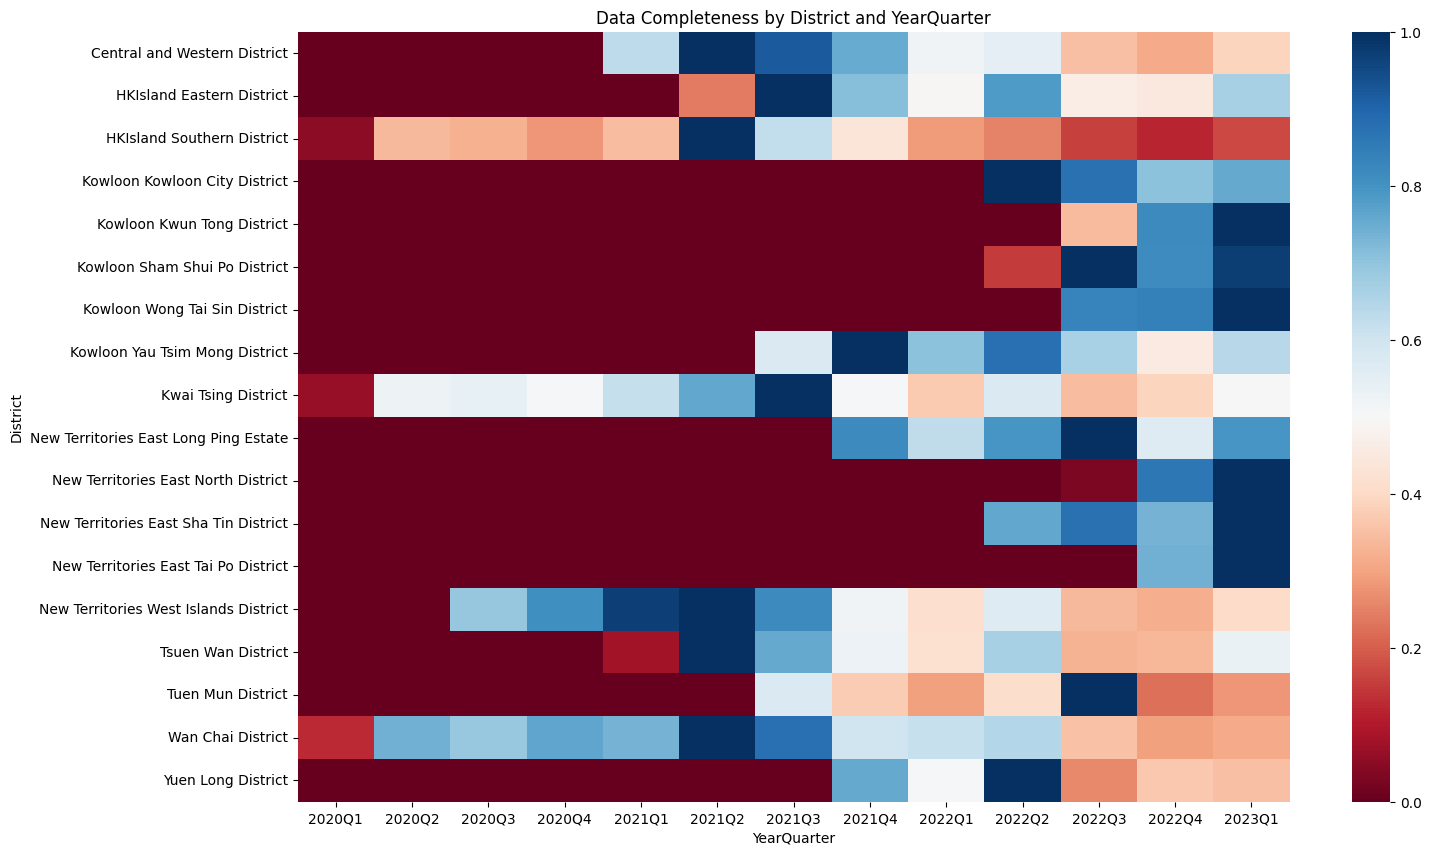

In [ ]:
# Assessing data completeness
# Load your dataset (ensure `merged_dataset` is already imported)
# Assuming `merged_dataset` is the dataset displayed in your screenshot

# Step 1: Create a pivot table to calculate data completeness
data_completeness = (
    merged_dataset
    .groupby(['district', 'YearQuarter'])['saleable_area(ft^2)']  # Use a key column like 'saleable_area(ft^2)' to check for non-null values
    .count()  # Count non-null values
    .unstack(fill_value=0)  # Create a pivot table with 'district' as rows and 'YearQuarter' as columns
)

# Step 2: Convert counts to a fraction of total rows per district and quarter
# Assume that at least one entry per district/quarter is required for full data presence
data_completeness_fraction = data_completeness.apply(lambda row: row / row.max(), axis=1)

# Step 3: Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(data_completeness_fraction, annot=False, cmap="RdBu", cbar=True)
plt.title("Data Completeness by District and YearQuarter")
plt.xlabel("YearQuarter")
plt.ylabel("District")
plt.show()

# Optional: Save the data completeness fraction to a CSV for further analysis
data_completeness_fraction.to_csv("data_completeness_fraction.csv")

From the abve early quarters (2020 Q1–Q3) exhibit substantial gaps across most districts, which could hinder time-series modeling due to insufficient data for trend analysis. Districts like HKIsland Southern,Kwai Tsing, and Wan Chai show better completeness in early periods, while others, such as New Territories East Long Ping Estate and Yuen Long District, remain sparse even in later quarters.

From 2021 onward, data completeness improves, with most districts achieving nearly full coverage.

Incomplete data can lead to challenges such as overfitting, biased predictions, or reduced model generalizability. To mitigate this, focus on later periods, impute missing data cautiously, and exclude districts with excessive gaps to enhance model performance.

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109851 entries, 7 to 159611
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   saleable_area(ft^2)  109851 non-null  int64         
 1   unit_rate            109851 non-null  int64         
 2   district             109851 non-null  object        
 3   floor                109851 non-null  float64       
 4   CPI                  109851 non-null  int64         
 5   PC                   109851 non-null  int64         
 6   IR                   109851 non-null  int64         
 7   MW                   109851 non-null  int64         
 8   M3                   109851 non-null  int64         
 9   SD                   109851 non-null  int64         
 10  UR                   109851 non-null  int64         
 11  GDP                  109851 non-null  int64         
 12  CI                   109851 non-null  int64         
 13  HSI                

# CLEANING THE DATA SET

The dataset faces several issues, including missing data for earlier periods (notably 2020) and incomplete coverage in the **New Territories (NTEast and NTWest)**. Errors in data entry (e.g., **Wanchai**) lead to extreme outliers, such as unit rates exceeding **HK$70,000–140,000 per sq. ft.**, while a right-skewed distribution reflects noise from unrecorded features (e.g., sea views, luxury flats). Overrepresentation of **Hong Kong Island** and sparse data in districts like **Kowloon City** exacerbate regional imbalances. To address this, drop 2020 data, remove extreme outliers (>3 SD), eliminate invalid entries (prices ≤0), and balance regional representation by filtering or downsampling districts.

In [ ]:
# Step 1: Print the initial shape of the dataset
print("Initial dataset shape:", merged_dataset.shape)

# Step 2: Remove data from incomplete earlier periods (2020Q1 to 2020Q4)
merged_dataset = merged_dataset[merged_dataset['YearQuarter'] > '2020Q4']

# Step 3: Drop districts with sparse data (e.g., Kowloon City and Wong Tai Sin)
sparse_districts = ['Kowloon City District', 'Wong Tai Sin District']
merged_dataset = merged_dataset[~merged_dataset['district'].isin(sparse_districts)]

# Step 4: Handle overrepresentation by downsampling Hong Kong Island districts
hk_island_districts = [
    'Central and Western District',
    'Eastern District',
    'Southern District',
    'Wan Chai District'
]

# Downsample to balance Hong Kong Island districts
for district in hk_island_districts:
    district_rows = merged_dataset[merged_dataset['district'] == district]
    max_rows = int(0.05 * len(merged_dataset))  # Set threshold (e.g., 5% of total rows)
    if len(district_rows) > max_rows:
        merged_dataset = merged_dataset.drop(district_rows.index[max_rows:])

# Step 5: Remove rows with invalid prices (prices ≤ 0)
merged_dataset = merged_dataset[merged_dataset['new_price'] > 0]

# Step 6: Remove extreme global outliers using 1 SDs for unit_rate and price
for col in ['unit_rate', 'new_price']:
    mean, std = merged_dataset[col].mean(), merged_dataset[col].std()
    merged_dataset = merged_dataset[(merged_dataset[col] >= mean - 1 * std) &
                                     (merged_dataset[col] <= mean + 1 * std)]

# Step 7: Remove rows with saleable area ≤ 0 (invalid entries)
merged_dataset = merged_dataset[merged_dataset['saleable_area(ft^2)'] > 0]

# Step 8: Remove properties with new_price outside the range of 1 to 20 million
merged_dataset = merged_dataset[(merged_dataset['new_price'] >= 1_000_000) &  # At least 1 million
                                 (merged_dataset['new_price'] <= 20_000_000)]  # At most 20 million

# Print the final shape of the dataset
print("Final dataset shape:", merged_dataset.shape)

Initial dataset shape: (109851, 27)
Final dataset shape: (72663, 27)


# CHECK THE CLEANED DATASET

In [ ]:
merged_dataset.head()

,saleable_area(ft^2),unit_rate,district,floor,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price,YearQuarter,region,floor_height,floor_size,price_bucket,is_outlier
7,423,15792,Kowloon Kowloon City District,22.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,6680016,2023Q1,KLN,floor_21to25,small400600,5.0,False
14,761,15857,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,12067177,2023Q1,KLN,floor_11to13,compact600800,10.0,False
15,320,13717,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,4389440,2023Q1,KLN,floor_11to13,micro200400,0.0,False
16,519,16541,Kowloon Kowloon City District,29.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,8584779,2023Q1,KLN,floor_26to30,small400600,5.0,False
17,699,14721,Kowloon Kowloon City District,24.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,10289979,2023Q1,KLN,floor_21to25,compact600800,10.0,False


In [ ]:
# Drop the specified columns from the DataFrame
merged_dataset = merged_dataset.drop(columns=["price_bucket", "is_outlier"], errors="ignore")


In [ ]:
merged_dataset.head()

,saleable_area(ft^2),unit_rate,district,floor,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price,YearQuarter,region,floor_height,floor_size
7,423,15792,Kowloon Kowloon City District,22.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,6680016,2023Q1,KLN,floor_21to25,small400600
14,761,15857,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,12067177,2023Q1,KLN,floor_11to13,compact600800
15,320,13717,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,4389440,2023Q1,KLN,floor_11to13,micro200400
16,519,16541,Kowloon Kowloon City District,29.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,8584779,2023Q1,KLN,floor_26to30,small400600
17,699,14721,Kowloon Kowloon City District,24.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,10289979,2023Q1,KLN,floor_21to25,compact600800


Frequency Distribution for 'district':
 district
Tuen Mun District                        6197
Yuen Long District                       6102
Tsuen Wan District                       5249
New Territories East Long Ping Estate    4820
New Territories East Tai Po District     4667
New Territories East North District      4617
Kowloon Kwun Tong District               4332
HKIsland Eastern District                4279
New Territories East Sha Tin District    4273
Kowloon Wong Tai Sin District            4145
Kowloon Sham Shui Po District            4080
Kowloon Kowloon City District            3850
Kowloon Yau Tsim Mong District           3630
Kwai Tsing District                      3402
Central and Western District             2928
New Territories West Islands District    2231
HKIsland Southern District               1993
Wan Chai District                        1868
Name: count, dtype: int64

Summary Statistics for Numerical Columns:
       saleable_area(ft^2)     unit_rate         floor

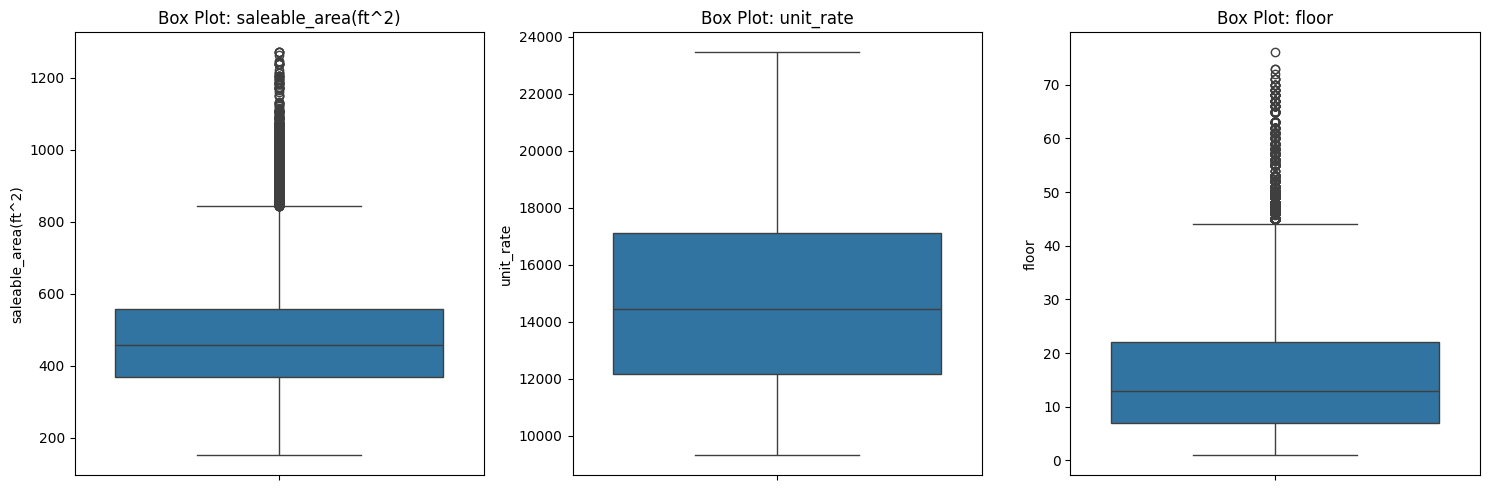

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency Distribution for 'district' (Categorical Column)
district_counts = merged_dataset['district'].value_counts()
print("Frequency Distribution for 'district':\n", district_counts)

# Summary Statistics for Numerical Columns
print("\nSummary Statistics for Numerical Columns:")
print(merged_dataset[['saleable_area(ft^2)', 'unit_rate', 'floor']].describe())

# Box Plots for Numerical Columns
plt.figure(figsize=(15, 5))

# Box plot for 'saleable_area(ft^2)'
plt.subplot(1, 3, 1)
sns.boxplot(y=merged_dataset['saleable_area(ft^2)'])
plt.title('Box Plot: saleable_area(ft^2)')

# Box plot for 'unit_rate'
plt.subplot(1, 3, 2)
sns.boxplot(y=merged_dataset['unit_rate'])
plt.title('Box Plot: unit_rate')

# Box plot for 'floor'
plt.subplot(1, 3, 3)
sns.boxplot(y=merged_dataset['floor'])
plt.title('Box Plot: floor')

plt.tight_layout()
plt.show()

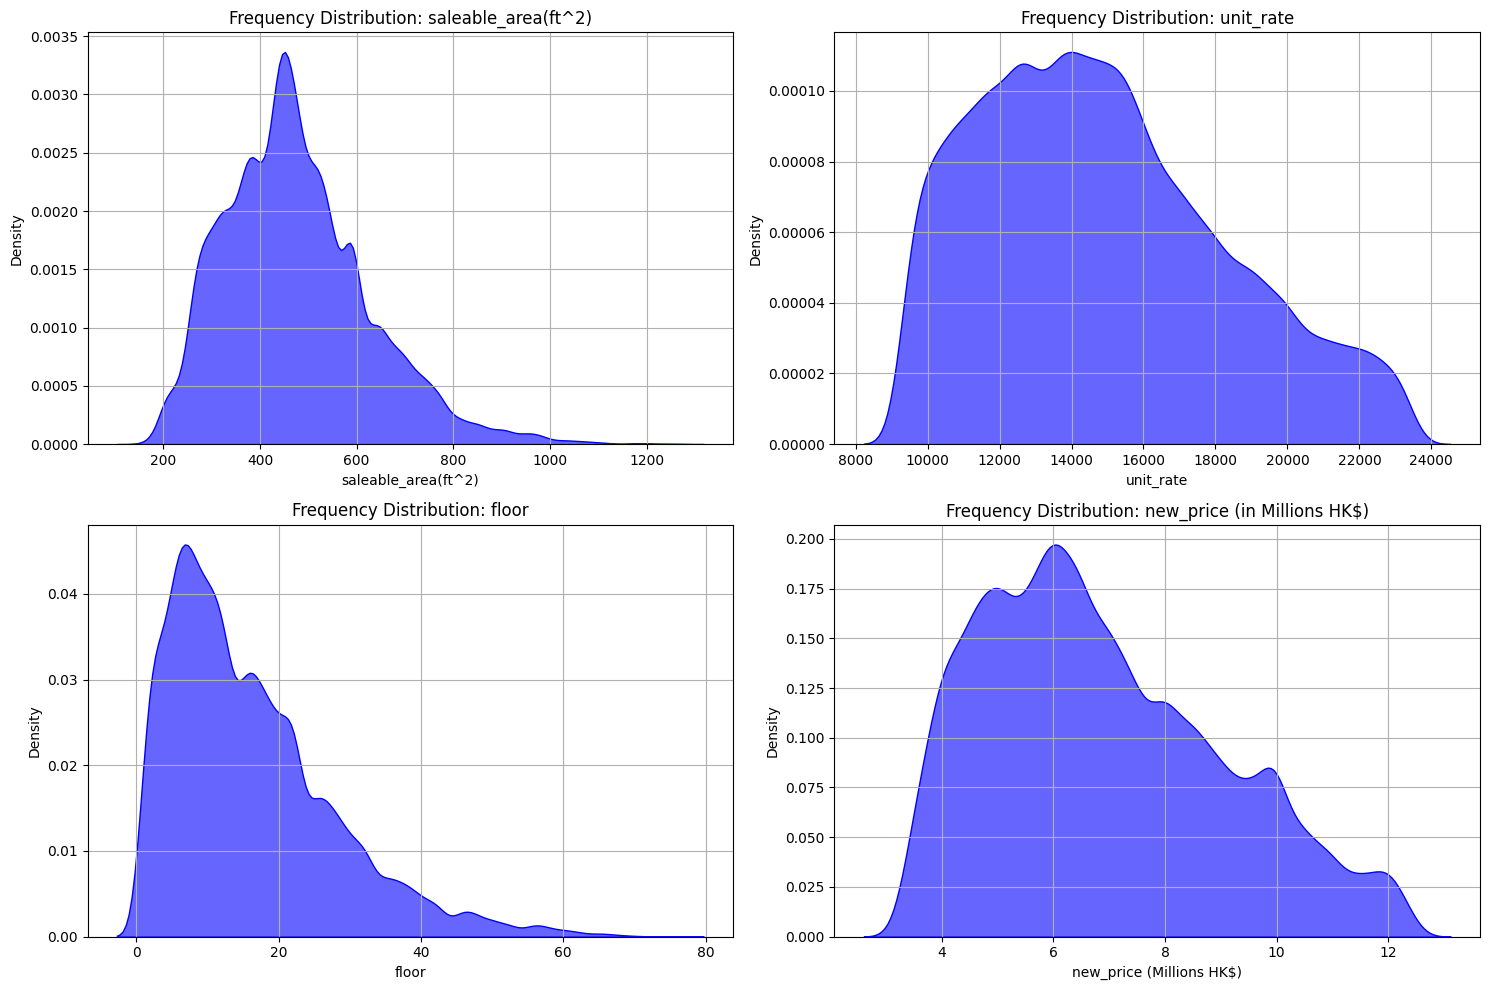

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical columns to plot
numerical_columns = ['saleable_area(ft^2)', 'unit_rate', 'floor', 'new_price']

# Filter existing columns from the dataset
columns_to_plot = [col for col in numerical_columns if col in merged_dataset.columns]

# Set up the figure and axes
plt.figure(figsize=(15, 10))

# Loop through each column and create a subplot
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns layout

    # For new_price, divide values by 1,000,000 and update the label
    if column == 'new_price':
        sns.kdeplot(data=merged_dataset, x=merged_dataset['new_price'] / 1_000_000, fill=True, color='blue', alpha=0.6)
        plt.title('Frequency Distribution: new_price (in Millions HK$)')
        plt.xlabel('new_price (Millions HK$)')
    else:
        sns.kdeplot(data=merged_dataset, x=column, fill=True, color='blue', alpha=0.6)
        plt.title(f'Frequency Distribution: {column}')
        plt.xlabel(column)

    plt.ylabel('Density')
    plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Linear Regression for new_price vs saleable_area(ft^2):
Equation: new_price = 10366.65 * saleable_area(ft^2) + 1943087.09
Mean Squared Error: 2170609092414.15
R-squared: 0.53

Linear Regression for new_price vs floor:
Equation: new_price = 49036.36 * floor + 6078267.34
Mean Squared Error: 4254809555257.21
R-squared: 0.07



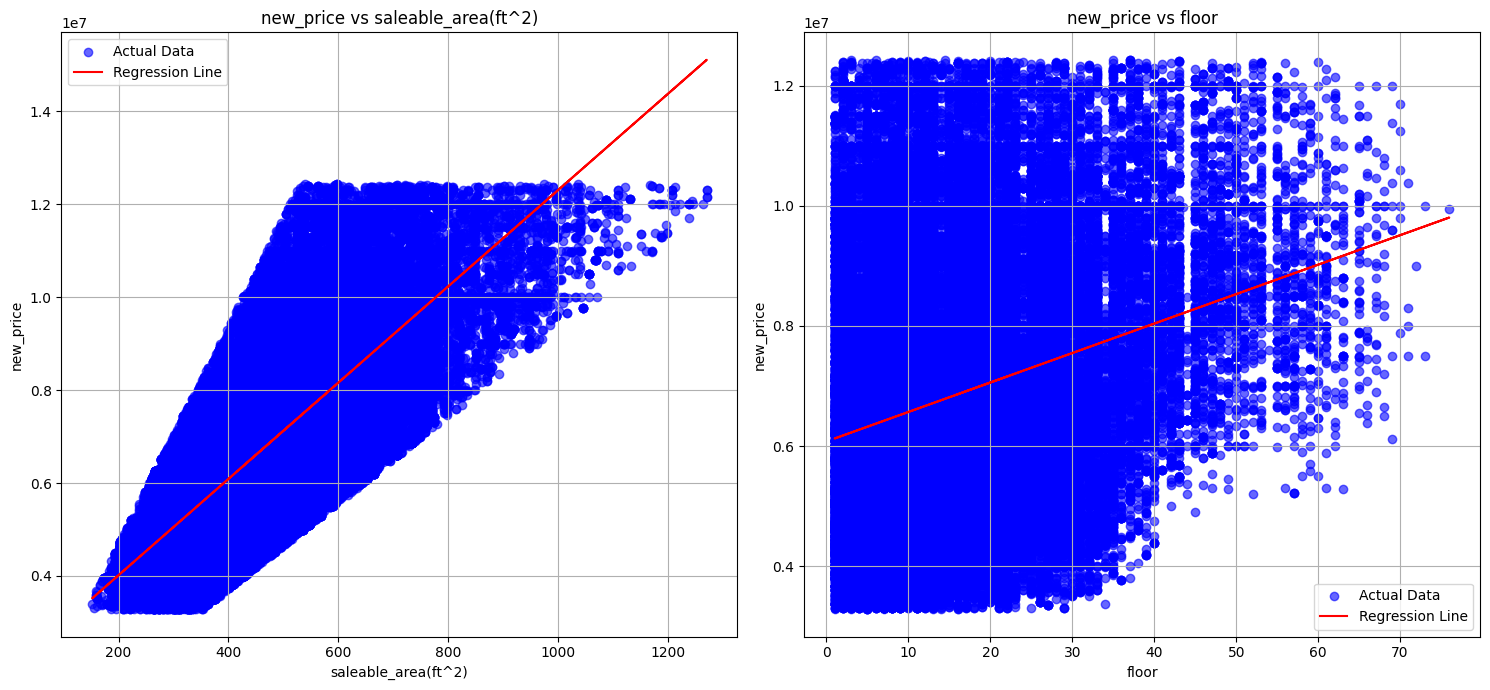

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Columns to analyze (removed 'unit_rate')
columns_to_analyze = ['saleable_area(ft^2)', 'floor']

# Set up the figure for subplots
plt.figure(figsize=(15, 7))

# Loop through each column and perform linear regression
for i, column in enumerate(columns_to_analyze, 1):
    if column in merged_dataset.columns and 'new_price' in merged_dataset.columns:
        # Remove rows with missing values in the selected columns
        data = merged_dataset[['new_price', column]].dropna()

        # Define predictor (X) and response (y)
        X = data[column].values.reshape(-1, 1)  # Reshape for sklearn
        y = data['new_price'].values

        # Initialize and fit the Linear Regression model
        model = LinearRegression()
        model.fit(X, y)

        # Make predictions
        y_pred = model.predict(X)

        # Coefficients and intercept
        slope = model.coef_[0]
        intercept = model.intercept_

        # Metrics
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        # Print the regression equation and metrics (optional)
        print(f"Linear Regression for new_price vs {column}:")
        print(f"Equation: new_price = {slope:.2f} * {column} + {intercept:.2f}")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R-squared: {r2:.2f}\n")

        # Plot scatter and regression line in a subplot
        plt.subplot(1, 2, i)  # Create a grid layout (1 row, 2 columns)
        plt.scatter(X, y, color='blue', label='Actual Data', alpha=0.6)
        plt.plot(X, y_pred, color='red', label='Regression Line')
        plt.title(f'new_price vs {column}')
        plt.xlabel(column)
        plt.ylabel('new_price')
        plt.legend()
        plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

There is a strong correlation between `saleable_area(ft^2)` and `new_price`, as larger properties generally cost more. Additionally, there is a weak but noticeable correlation between `new_price` and `floor`, as higher floors may increase property value. Based on these relationships, it would be expected that `saleable_area(ft^2)` and `unit_rate` (calculated as `new_price / saleable_area(ft^2)`) should also show a strong correlation. However, this is not the case because dividing `new_price` by `saleable_area(ft^2)` normalizes the linear relationship, making `unit_rate` relatively independent of property size. Variability in `new_price` (due to location, amenities, or other factors) introduces noise, further obscuring any correlation. For machine learning models, this lack of correlation can diminish the predictive value of `unit_rate` as a feature since it doesn’t add new information. Using both `saleable_area(ft^2)` and `unit_rate` together may lead to redundancy or multicollinearity, degrading model performance and interpretability.

In [ ]:
# Calculate the unit rate on-the-fly and compare with the existing unit_rate column
discrepancy_rows = merged_dataset[
    (merged_dataset['new_price'] / merged_dataset['saleable_area(ft^2)']) != merged_dataset['unit_rate']
]

# Check if there are discrepancies
if discrepancy_rows.empty:
    print("No differences found between calculated unit rate and unit rate in the dataset.")
else:
    # Display rows with discrepancies
    print(discrepancy_rows[['saleable_area(ft^2)', 'new_price', 'unit_rate']])

No differences found between calculated unit rate and unit rate in the dataset.


Average new_price per district:
district
Tuen Mun District                        5.938909e+06
New Territories East Tai Po District     6.278440e+06
New Territories East North District      6.282494e+06
Kwai Tsing District                      6.481831e+06
Kowloon Kwun Tong District               6.576030e+06
New Territories East Sha Tin District    6.715131e+06
Kowloon Wong Tai Sin District            6.742189e+06
Kowloon Yau Tsim Mong District           6.775424e+06
Kowloon Sham Shui Po District            6.826046e+06
Kowloon Kowloon City District            6.858876e+06
Tsuen Wan District                       7.019194e+06
Yuen Long District                       7.157120e+06
Central and Western District             7.194258e+06
Wan Chai District                        7.231779e+06
HKIsland Eastern District                7.426131e+06
HKIsland Southern District               7.719473e+06
New Territories East Long Ping Estate    7.886404e+06
New Territories West Islands District    

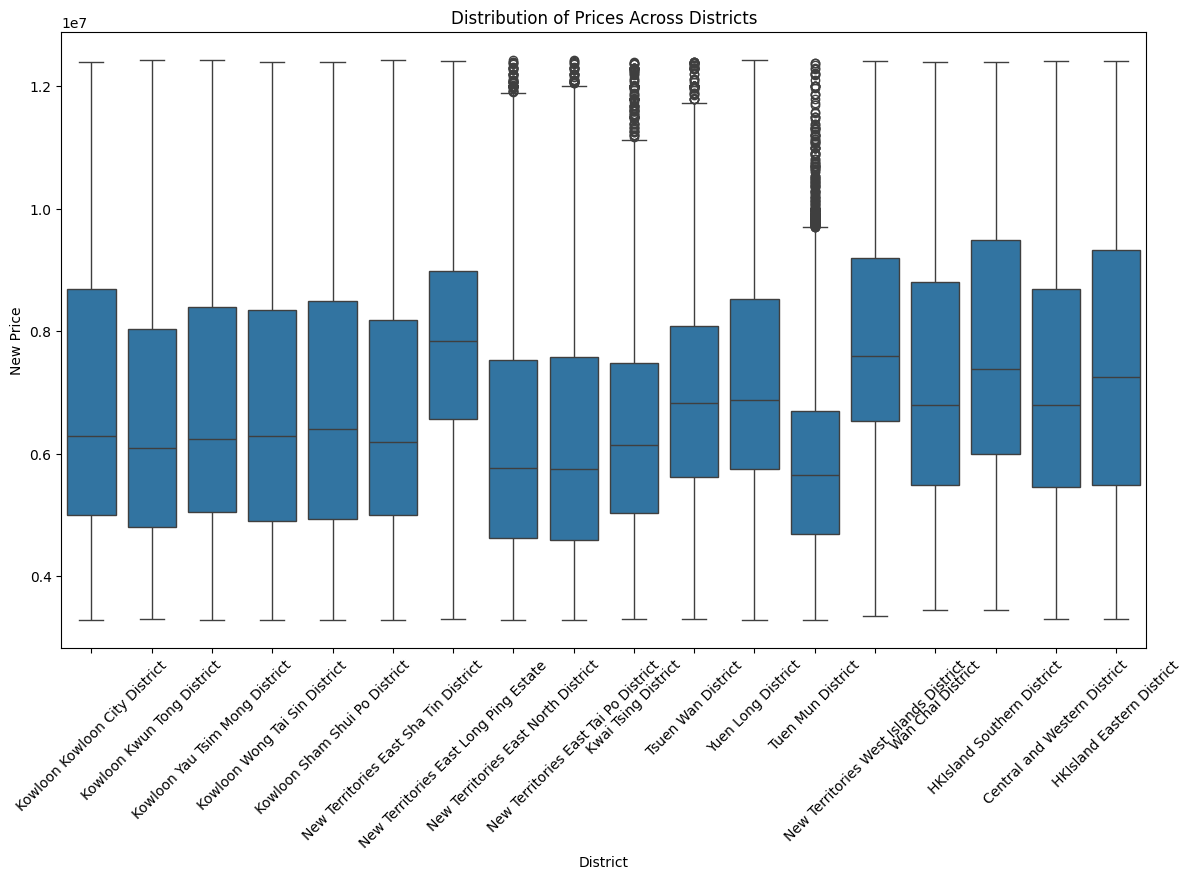

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group-Based Analysis (Average new_price per district)
district_price_summary = merged_dataset.groupby('district')['new_price'].mean().sort_values()
print("Average new_price per district:")
print(district_price_summary)

# Step 2: Box Plot to Show Distribution of Prices by District
plt.figure(figsize=(14, 8))
sns.boxplot(x='district', y='new_price', data=merged_dataset)
plt.title('Distribution of Prices Across Districts')
plt.xlabel('District')
plt.ylabel('New Price')
plt.xticks(rotation=45)
plt.show()


# SAVING CLEANED DATASET FOR NEXT STAGE

In [ ]:
merged_dataset.shape

(72663, 25)

In [ ]:
merged_dataset.head()

,saleable_area(ft^2),unit_rate,district,floor,CPI,PC,IR,MW,M3,SD,UR,GDP,CI,HSI,LTV,HS,SOLD,PG,LS,FormattedDate,new_price,YearQuarter,region,floor_height,floor_size
7,423,15792,Kowloon Kowloon City District,22.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,6680016,2023Q1,KLN,floor_21to25,small400600
14,761,15857,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,12067177,2023Q1,KLN,floor_11to13,compact600800
15,320,13717,Kowloon Kowloon City District,12.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,4389440,2023Q1,KLN,floor_11to13,micro200400
16,519,16541,Kowloon Kowloon City District,29.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,8584779,2023Q1,KLN,floor_26to30,small400600
17,699,14721,Kowloon Kowloon City District,24.0,0,351,3,18,17,0,3,90,66,20400,1,2184,4968,0,0,2023-03-08,10289979,2023Q1,KLN,floor_21to25,compact600800


In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72663 entries, 7 to 159610
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   saleable_area(ft^2)  72663 non-null  int64         
 1   unit_rate            72663 non-null  int64         
 2   district             72663 non-null  object        
 3   floor                72663 non-null  float64       
 4   CPI                  72663 non-null  int64         
 5   PC                   72663 non-null  int64         
 6   IR                   72663 non-null  int64         
 7   MW                   72663 non-null  int64         
 8   M3                   72663 non-null  int64         
 9   SD                   72663 non-null  int64         
 10  UR                   72663 non-null  int64         
 11  GDP                  72663 non-null  int64         
 12  CI                   72663 non-null  int64         
 13  HSI                  72663 non-null

In [ ]:
# Import the required modules
from google.colab import drive
import os  # For file path verification

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/M5 Code and Data/Std_Datasetv2.csv'

# Save the merged dataset to Google Drive
try:
    merged_dataset.to_csv(file_path, index=False)
    print(f"File 'Std_Datasetv2.csv' has been saved successfully!")
    print(f"Full file path: {file_path}")
except Exception as e:
    print(f"Error while saving the file: {e}")

# Verify if the file exists
if os.path.exists(file_path):
    print(f"File verification successful: 'Std_Datasetv2.csv' exists in the directory.")
else:
    print(f"File 'Std_Datasetv2.csv' was not found in the directory!")

# Optionally unmount the drive (if needed)
drive.flush_and_unmount()
print("Drive unmounted. Please refresh Google Drive and remount if necessary.")

Mounted at /content/drive
File 'Std_Datasetv2.csv' has been saved successfully!
Full file path: /content/drive/My Drive/Colab Notebooks/M5 Code and Data/Std_Datasetv2.csv
File verification successful: 'Std_Datasetv2.csv' exists in the directory.
Drive unmounted. Please refresh Google Drive and remount if necessary.
